- [Hotel Booking Demand & Pricing](#-hotel-booking-demand--pricing)
- [Metadata](#-metadata)
- [Deep Dive](#-deep-dive)
    - [Setup & Data Preparation](#-setup--data-preparation)
    - [Data Cleaning & Preparation](#-data-cleaning--preparation)
        - [Data Accuracy & Integrity](#-data-accuracy--integrity)
        - [Handling Missing Data](#-handling-missing-data)
        - [Duplicate Data Detection](#-duplicate-data-detection)
        - [Validating Data Types](#-validating-data-types)
        - [Outlier Detection](#-outlier-detection)
    - [Inserting Processed Data into Database](#-inserting-processed-data-into-database)
        - [Creating the Database](#-creating-the-database)
        - [Connecting to PostgreSQL](#-connecting-to-postgresql)
        - [Creating the Table](#-creating-the-table)
        - [Inserting Data into the Table](#-inserting-data-into-the-table)
    - [Exploratory Data Analysis (EDA)](#-exploratory-data-analysis-eda)
        - [Cancellation Rate vs Market Segment](#-cancellation-rate-vs-market-segment)
        - [Impact of Lead Time on Cancellations](#-impact-of-lead-time-on-cancellations)
        - [Numerical Features Correlation with Key Variables](#-numerical-features-correlation-with-key-variables)
        - [Categorical Features Correlation with Key Variables](#-categorical-features-correlation-with-key-variables)
        - [Time Series Analysis of Average Daily Rate](#-time-series-analysis-of-average-daily-rate)
- [Average Daily Rate (ADR) Forecasting](#-average-daily-rate-adr-forecasting)
    - [Overview](#-overview)
    - [Model Selection](#-model-selection)
    - [Ensemble Model: CatBoost Regressor](#-ensemble-model--catboost-regressor)
        - [Initial Feature Selection](#-initial-feature-selection)
        - [Preprocessing & Model Training](#-preprocessing--model-training)
        - [Time Series Cross-Validation & Hyperparameter Tunning](#-time-series-crossvalidation--hyperparameter-tunning)
        - [Feature Importance](#-feature-importance)
        - [Evaluation](#-evaluation)
    - [Ensemble Model: Random Forest (RF)](#-ensemble-mode--random-forest-rf)
        - [Feature Engineering](#-feature-engineering)
            - [Time-Series Specific Features](#-timeseries-specific-features)
            - [Non-Time-Series Specific Features](#-nontimeseries-specific-features)
        - [RF with New Features](#-rf-with-new-features)
        - [RF without New Features](#-rf-without-new-features)
    - [Summary of the Results](#-summary-of-the-results)
    - [Conclusion & Business Implications](#-conclusion--business-implications)

# Overview

Understanding hotel booking demand is crucial for optimizing pricing strategies, minimizing cancellations, and maximizing revenue. Hotel reservations fluctuate based on seasonal trends, booking lead time, and customer preferences. Pricing decisions directly impact demand, as competitive rates can attract more bookings, while cancellation patterns influence revenue forecasting and inventory management. Analyzing these factors allows hotels to adjust their pricing dynamically, improve occupancy rates, and implement strategies to reduce cancellations.

Our analysis focuses on cancellation behavior and pricing strategies to identify patterns that impact hotel revenue and operational efficiency. By examining key factors such as lead time, market segment, and previous cancellations, we can provide actionable insights to help hotels mitigate revenue losses. Additionally, we perform average Daily Rate (ADR) forecasting to predict future booking trends, enabling hotels to optimize pricing, staffing, and resource allocation. Accurate forecasting enhances decision-making, reduces uncertainty, and ensures better financial planning for the hospitality industry.

<span style="font-size: 20px;">**Dataset**

We are using the publicly available hotel booking demand dataset from [Kaggle](https://www.kaggle.com/datasets/jessemostipak/hotel-booking-demand), which contains three years of reservation data for two hotels in Portugal. This dataset provides detailed insights into bookings, cancellations, customer demographics, and pricing, making it valuable for demand forecasting and revenue optimization.

# Metadata

**hotelHotel:** H1 = Resort Hotel or H2 = City Hotel

**is_canceled:** Value indicating if the booking was canceled (1) or not (0)

**lead_time:** Number of days that elapsed between the entering date of the booking into the PMS and the arrival date

**arrival_date_year:** Year of arrival date

**arrival_date_month:** Month of arrival date

**arrival_date_week_number:** Week number of year for arrival date

**arrival_date_day_of_month:** Day of arrival date

**stays_in_weekend_nights:** Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel

**stays_in_week_nights:** Number of weeknights (Monday to Friday) the guest stayed or booked to stay at the hotel

**adults:** Number of adults

**children:** Number of children

**babies:** Number of babies

**meal:** Type of meal booked. Categories are presented in standard hospitality meal packages: Undefined/SC – no meal package; BB – Bed & Breakfast; HB – Half board (breakfast and one other meal – usually dinner); FB – Full board (breakfast, lunch and dinner)

**country:** Country of origin. Categories are represented in the ISO 3155–3:2013 format

**market_segment:** Market segment designation. In categories, the term “TA” means “Travel Agents” and “TO” means “Tour Operators”

**distribution_channel:** Booking distribution channel. The term “TA” means “Travel Agents” and “TO” means “Tour Operators”

**is_repeated_guest:** Value indicating if the booking name was from a repeated guest (1) or not (0)

**previous_cancellations:** Number of previous bookings that were cancelled by the customer prior to the current booking

**previous_bookings_not_canceled:** Number of previous bookings not cancelled by the customer prior to the current booking

**reserved_room_type:** Code of the room type reserved. Code is presented instead of designation for anonymity reasons.

**assigned_room_type:** Code for the type of room assigned to the booking. Sometimes, the assigned room type differs from the reserved room type due to hotel operation reasons (e.g. overbooking) or by customer request. Code is presented instead of designation for anonymity reasons.

**booking_changes:** Number of changes/amendments made to the booking from the moment the booking was entered on the PMS until the moment of check-in or cancellation

**deposit_type:** Indication of whether the customer deposited to guarantee the booking. This variable can assume three categories: No Deposit, Non-Refund, and Refundable.

**agent:** ID of the travel agency that made the booking

**company:** ID of the company/entity that made the booking or responsible for paying the booking. ID is presented instead of designation for anonymity reasons

**days_in_waiting_list:** Number of days the booking was in the waiting list before it was confirmed to the customer

**customer_type:** Type of booking, assuming one of four categories: Contract - when the booking has an allotment or other type of contract associated to it; Group – when the booking is associated to a group; Transient – when the booking is not part of a group or contract, and is not associated to other transient booking; Transient-party – when the booking is transient, but is associated to at least other transient booking

**adr:** Average Daily Rate is defined by dividing the sum of all lodging transactions by the total number of staying nights

**required_car_parking_spaces:** Number of car parking spaces required by the customer

**total_of_special_requests:** Number of special requests made by the customer (e.g. twin bed or high floor)

**reservation_status:** Reservation last status, assuming one of three categories: Canceled – booking was canceled by the customer; Check-Out – customer has checked in but already departed; No-Show – customer did not check-in and did inform the hotel of the reason why

**reservation_status_date:** The Date at which the last status was set. This variable can be used in conjunction with the Reservation Status to understand when the booking was canceled or when the customer checked out of the hotel

# Deep Dive

## Setup & Data Preparation

In [13]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#import cufflinks as cf
#import plotly.graph_objects as go

import warnings
warnings.filterwarnings("ignore")

In [14]:
df.shape

(119390, 32)

In [277]:
import os
import zipfile
import shutil


# Dynamically finding the project root (going up until a folder containing "data" is found)
base_path = os.getcwd()

while not os.path.exists(os.path.join(base_path, "data")) and base_path != os.path.dirname(base_path):
    base_path = os.path.dirname(base_path)  # Move up one level

# If no "data" folder is found, assume the project root is the current working directory
project_path = base_path if os.path.exists(os.path.join(base_path, "data")) else os.getcwd()

# Defining paths based on the detected project root
data_folder = os.path.join(project_path, "data")
os.makedirs(data_folder, exist_ok=True)  # Ensuring "data" folder exists

zip_file_path = os.path.join(data_folder, "hotel-booking-demand.zip")
csv_file_path = os.path.join(data_folder, "hotel_bookings.csv")

# Removing any "Downloads" folder inside the project (if it exists)
downloads_path = os.path.join(project_path, "Downloads")
if os.path.exists(downloads_path):
    shutil.rmtree(downloads_path)

# Checking if the dataset is already extracted; if not, download & extract
if not os.path.exists(csv_file_path):
    print("Dataset not found locally. Downloading and extracting...")

    # Downloading the dataset using Kaggle API
    !kaggle datasets download -d jessemostipak/hotel-booking-demand -p "{data_folder}"

    # Extracting the ZIP file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(data_folder)

# Loading CSV into a Pandas DataFrame
df = pd.read_csv(csv_file_path)

In [ ]:
# df = pd.read_csv('hotel_bookings.csv',parse_dates = True)

## Data Cleaning & Preparation

- Conduct a deep conceptual and logical analysis to assess data accuracy and integrity.

- Check data types for consistency and resolve any discrepancies.

- Detect and remove duplicate records to ensure uniqueness.

- Detect and evaluate missing values and determine the appropriate action.

- Handle missing data based on context by either removing or imputing values.

- Identify and address outliers to prevent distortion in the analysis.

### Data Accuracy & Integrity

Based on the metadata and the nature of the data, several potential issues and recommendations for better data validation and understanding have been identified. These checks help flag inconsistencies, outliers, and potential data entry errors. We detect these inconsistencies and categorize them into predefined categories—critical, inconsistency, and anomaly detection. The categorization helps prioritize the necessary actions, which will be defined further in this section.

In [16]:
df.head(5)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

Some of the data types need to be changed; for example, children should be int64 instead of float64. However, we address data types after handling missing values, as applying type changes to null values can result in errors.

In [18]:
df.shape

(119390, 32)

<span style="font-size: 22px;">**Inconsistency Importance Categorization:**

- **Critical Errors** (e.g., bookings with no guests, negative ADR) → Remove
- **Inconsistencies** (e.g., mismatched room types for cancellations) → Impute or Correct
- **Anomaly Detection** (e.g., excessive booking changes) → Flag for Further Review

Below are the identified inconsistencies, their corresponding categories, and the actions taken to address them:

<span style="font-size: 18px;">**Adults, Children, and Babies**

There should not be a case where all three variables — adults, children, and babies — are zero. A valid booking should involve at least one guest. If all three are zero, it suggests incorrect or missing data.
Check: If adults == 0, children == 0, and babies == 0, this is likely an issue that should be flagged or removed.

In [19]:
invalid_guests = df[(df['adults'] == 0) & (df['children'] == 0) & (df['babies'] == 0)]

**Category:**
Critical Error

Justification: A booking must include at least one guest. Rows where adults, children, and babies are all zero indicate incorrect data and should be removed.

In [20]:
df = df[~((df['adults'] == 0) & (df['children'] == 0) & (df['babies'] == 0))]

<span style="font-size: 18px;">**Lead Time and Booking Date**

The lead time (the number of days between booking date and arrival date) should make sense in the context of the booking date and arrival date. For instance, if the booking date is after the arrival date, it’s an error. A very short lead time (e.g., booking made on the day of arrival) is also worth reviewing.

It should be checked that the lead_time is a non-negative value.

In [21]:
invalid_lead_time = df[df['lead_time']<0]

**Category: Inconsistency**

Justification: The booking_date should always be before or on the arrival_date. Rows where lead time is negative should be flagged for review.

<span style="font-size: 18px;">**Negative ADR**

The Average Daily Rate (ADR) is a key metric in the hospitality industry used to assess the average revenue earned per available room per day.

ADR is calculated by dividing the total revenue generated from all hotel bookings for a given period by the total number of nights all guests stayed at the hotel during the same period. In theory, this value cannot be negative because the minimum income will be zero, as costs and expenses are not included in this calculation. 

If ADR is negative, it indicates that there’s an issue with the data or calculation.

In [22]:
invalid_adr = df[df['adr'] < 0]

**Category:** 
Critical Error

Justification: A negative ADR is impossible in a real-world scenario. These rows should either be removed or corrected if the error is systematic.

In [23]:
df = df[df['adr'] >= 0]

<span style="font-size: 18px;">**Overlapping Cancellations and No-Show**

There should be no cases where the booking is both canceled and marked as a No-Show. A canceled booking should not have a No-Show status, as it implies the guest did not show up due to a cancellation.

Ensuring consistency in booking status is crucial for maintaining data integrity, especially when the objective is to forecast cancellation patterns.

In [24]:
conflicting_status = df[(df['is_canceled'] == 1) & (df['reservation_status'] == 'No-Show')]

**Category:** 
Inconsistency

Justification: A reservation cannot be both canceled and a No-Show simultaneously. This inconsistency needs correction.

In [25]:
df.loc[(df['is_canceled'] == 1) & (df['reservation_status'] == 'No-Show'), 'reservation_status'] = 'Canceled'

<span style="font-size: 18px;">**Booking Changes**

If a booking has multiple changes (e.g., booking_changes > 0), it should be reasonable. If there are excessive changes (e.g., booking_changes greater than a certain threshold like 10), it might suggest either incorrect data entry or a highly unusual case that should be reviewed.

In [26]:
high_changes = df[df['booking_changes'] > 10]

**Category:**
Anomaly Detection

Justification: While some changes are normal, more than 10 changes is highly unusual and should be flagged for further review.

<span style="font-size: 18px;">**Repeated Guest and Previous Bookings**

If a customer has many previous bookings that were not canceled (which indicates they’ve been to the hotel before), it might be unusual for them not to be a repeated guest (i.e., is_repeated_guest == 0). This would be inconsistent because someone who has booked and showed up many times is likely a repeated guest.

A customer may have made a reservation but visited the hotel before the booking date for another reason. In such rare cases, allowing for a single exception is reasonable. Therefore, we use previous_bookings_not_canceled > 1 and is_repeated_guest = 0 instead of previous_bookings_not_canceled > 0 and is_repeated_guest = 0 to account for these rare occurrences.

In [27]:
inconsistent_guest_info = df[(df['is_repeated_guest'] == 0) & (df['previous_bookings_not_canceled'] > 1)]

**Category:** Inconsistency

Justification: A customer with more than one previous bookings should be identified as repeated guest.

In [28]:
df.loc[((df['is_repeated_guest'] == 0) & (df['previous_bookings_not_canceled'] > 1)), "is_repeated_guest"]=1

<span style="font-size: 18px;">**Booking by Group vs. Individual**

There should not be a case where a Group booking (customer_type == 'Group') has only one guest. A group booking should involve multiple guests. If customer_type == 'Group' and adults == 1, this should be flagged as an issue.

In [29]:
group_with_one_guest = df[(df['customer_type'] == 'Group') & (df['adults'] == 1)]

**Category:** Inconsistency

Justification: A group booking should involve multiple guests. If customer_type == 'Group' but only one adult is listed, the data is inconsistent. We replace 'Group' with the most frequent category of customer_type which is 'Transient'

In [30]:
df.loc[(df['customer_type'] == 'Group') & (df['adults'] <= 1), "customer_type"]= "transient"

<span style="font-size: 18px;">**Deposit Type and Booking Status**

Recommendation: If a customer has a deposit (deposit_type is not No Deposit), but the booking is canceled or marked as a No-Show, the deposit should typically be refunded, except in cases where the deposit is non-refundable. The deposit status is required to align with the booking status.

In [31]:
deposit_issue = df[(df['deposit_type'] != 'No Deposit') & (df['reservation_status'].isin(['Canceled', 'No-Show']))]

**Category:** Anomaly Detection (Possible Business Logic Violation)

Justification: If a booking is canceled or a No-Show, deposits should be refunded unless explicitly non-refundable. These cases should be reviewed.

<span style="font-size: 18px;">**Reservation Status vs Stay**

If a booking has a No-Show status or the customer is cancelled, it should not have any stay nights (stays_in_weekend_nights or stays_in_week_nights should be zero).

In such cases, the arrival date remains but isn't used for calculating the stay duration.
The assigned room type must match the reserved room type.

In [32]:
invalid_cancellation = df[((df['is_canceled'] == 1) | (df['reservation_status'] == 'No-Show')) & 
                         ((df['assigned_room_type'].astype(str) != df['reserved_room_type'].astype(str)) |
                          (df['stays_in_week_nights'] > 0) | 
                          (df['stays_in_weekend_nights'] > 0))]

**Category:** Inconsistency 

Justification: The issue arises from a logical inconsistency in how canceled or no-show bookings are treated in the data. A canceled or no-show booking should not have any recorded stay nights (both weekday and weekend), as the guest did not stay at the hotel.

In [33]:
df.loc[(((df['is_canceled'] == 1) | (df['reservation_status'] == 'No-Show')) & 
                    (df['assigned_room_type'].astype(str) != df['reserved_room_type'].astype(str))), "stays_in_week_nights"]=0

df.loc[(((df['is_canceled'] == 1) | (df['reservation_status'] == 'No-Show')) & 
                    (df['assigned_room_type'].astype(str) != df['reserved_room_type'].astype(str))), "stays_in_weekend_nights"]=0

<span style="font-size: 18px;">**Special Requests**

The total_of_special_requests column should typically not have excessively high values, as most guests would request 1 or 2 things (e.g., a high floor, twin beds). If there are unusually high values, it could indicate an error or a large group booking with specific requirements.

In [34]:
high_special_requests = df[(df['total_of_special_requests'] > 5) & (df['customer_type'] != 'Group')]

**Category:** Anomaly Detection

Justification: Flag records with unusually high special requests for further inspection, as they might indicate incorrect data or rare cases that need validation.

<span style="font-size: 18px;">**Market Segment vs Channel**

While market segments and channels may overlap, they serve distinct purposes.

- Channel refers to the medium used for booking. For example, did the guest book through the hotel's website, an OTA (Online Travel Agency), or by calling the hotel directly?

- Market Segment focuses on the characteristics and behavior of the guest rather than the booking method. For instance, a business traveler falls under the "Corporate" segment, regardless of whether they booked via the website, GDS (Global Distribution System), or a direct call. Market segments are typically determined by the rate code a guest books, which can be accessed through multiple channels.

There are cases of overlap. For example, a leisure traveler booking through an OTA is classified under the "OTA" market segment. 

**Why does this distinction matter?** OTA bookings usually come with higher costs than direct bookings. To optimize revenue, segmentation strategies should encourage direct leisure bookings over OTA bookings. Achieving this requires a more detailed and precise approach to market segmentation.

<span style="font-size: 18px;">**arrival_date_week_number:** 

The arrival_date_week_number column represents the week number of the year for the arrival date. We observe week number 53, which does not make sense as a year has 52 weeks. However, it is possible to encounter 53 weeks in some years due to the way weeks are calculated, specifically in systems that use the ISO 8601 standard.

Why does this happen?

The ISO 8601 system assigns weeks to years, and a year can have 53 weeks if:
- January 1st is a Thursday, or
- The year starts on a Wednesday, and the year is a leap year.

In both cases, the extra week happens because the first day of the year (or the first few days of the year) can still belong to the last week of the previous year, leading to a total of 53 weeks in that year.

<span style="font-size: 18px;">**arrival_date_month**

The arrival_date_month column contains month names as strings, which are not inherently ordered. To ensure clarity and consistency, we explicitly define their correct chronological order before mapping them to numerical values. This prevents potential confusion in future processing where numerical month values might be needed, ensuring January is always 1, February is 2, and so on.

In [35]:
# Ensuring that the ordered_months list is in the correct order before mapping
ordered_months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Sorting 'arrival_date_month' column based on the ordered month list
df['arrival_date_month'] = pd.Categorical(df['arrival_date_month'], categories=ordered_months, ordered=True)

df = df.sort_values(by='arrival_date_month')

#df['arrival_date_month'] = df['arrival_date_month'].astype('object')

In [36]:
# Ensuring the column is properly ordered
df['arrival_date_month'] = df['arrival_date_month'].astype('category')
df['arrival_date_month'].cat.categories

Index(['January', 'February', 'March', 'April', 'May', 'June', 'July',
       'August', 'September', 'October', 'November', 'December'],
      dtype='object')

In [37]:
# All good!!!
df['arrival_date_month'] = df['arrival_date_month'].astype('object')

### Handling Missing Data

In [38]:
# checking Null values
null = pd.DataFrame({'Null Values' : df.isnull().sum(), 'Percentage Null Values' : np.round(df.isnull().sum() / (df.shape[0]) * (100), 3) })

In [39]:
null[null["Null Values"]!=0]

,Null Values,Percentage Null Values
children,4,0.003
country,478,0.401
agent,16280,13.657
company,112441,94.323


**Missing Data in 'children' Column (0.003%):** 

We can fill the missing values with 0 (assuming children not being present is a reasonable default value).

In [40]:
df["children"].fillna(0, inplace=True)

**Missing Data in 'country' Column (0.409%):**

Since the missing values are for a small percentage of bookings, we can either:
- Fill in with the most frequent country (mode), assuming it's a reasonable approximation. (our choice here)
- If the country column is essential for analysis, we might need to investigate why it's missing and consider dropping these rows if they are unimportant.

In [41]:
df["country"].fillna(df['country'].mode()[0], inplace=True)

**Missing Data in 'agent' Column (13.686%):**

This is a large portion of data, and it doesn't make sense to drop them all. 

In this case, we can fill in with a default value, such as "Unknown" or the most frequent agent. Here, we choose to go with assigning a separate agent-ID category to missing values "-1".

In [42]:
df['agent'].fillna('-1', inplace=True)

**Missing Data in 'company' Column (94.307%):**

Since this column has a very high percentage of missing values, we can:

- Drop the column entirely if it's not critical for the analysis. (our choice)
- If it’s important for some reason, we can fill the missing values with a default value, such as "Unknown" or the most frequent company.

In [43]:
df.drop(columns= ['company'], inplace=True)

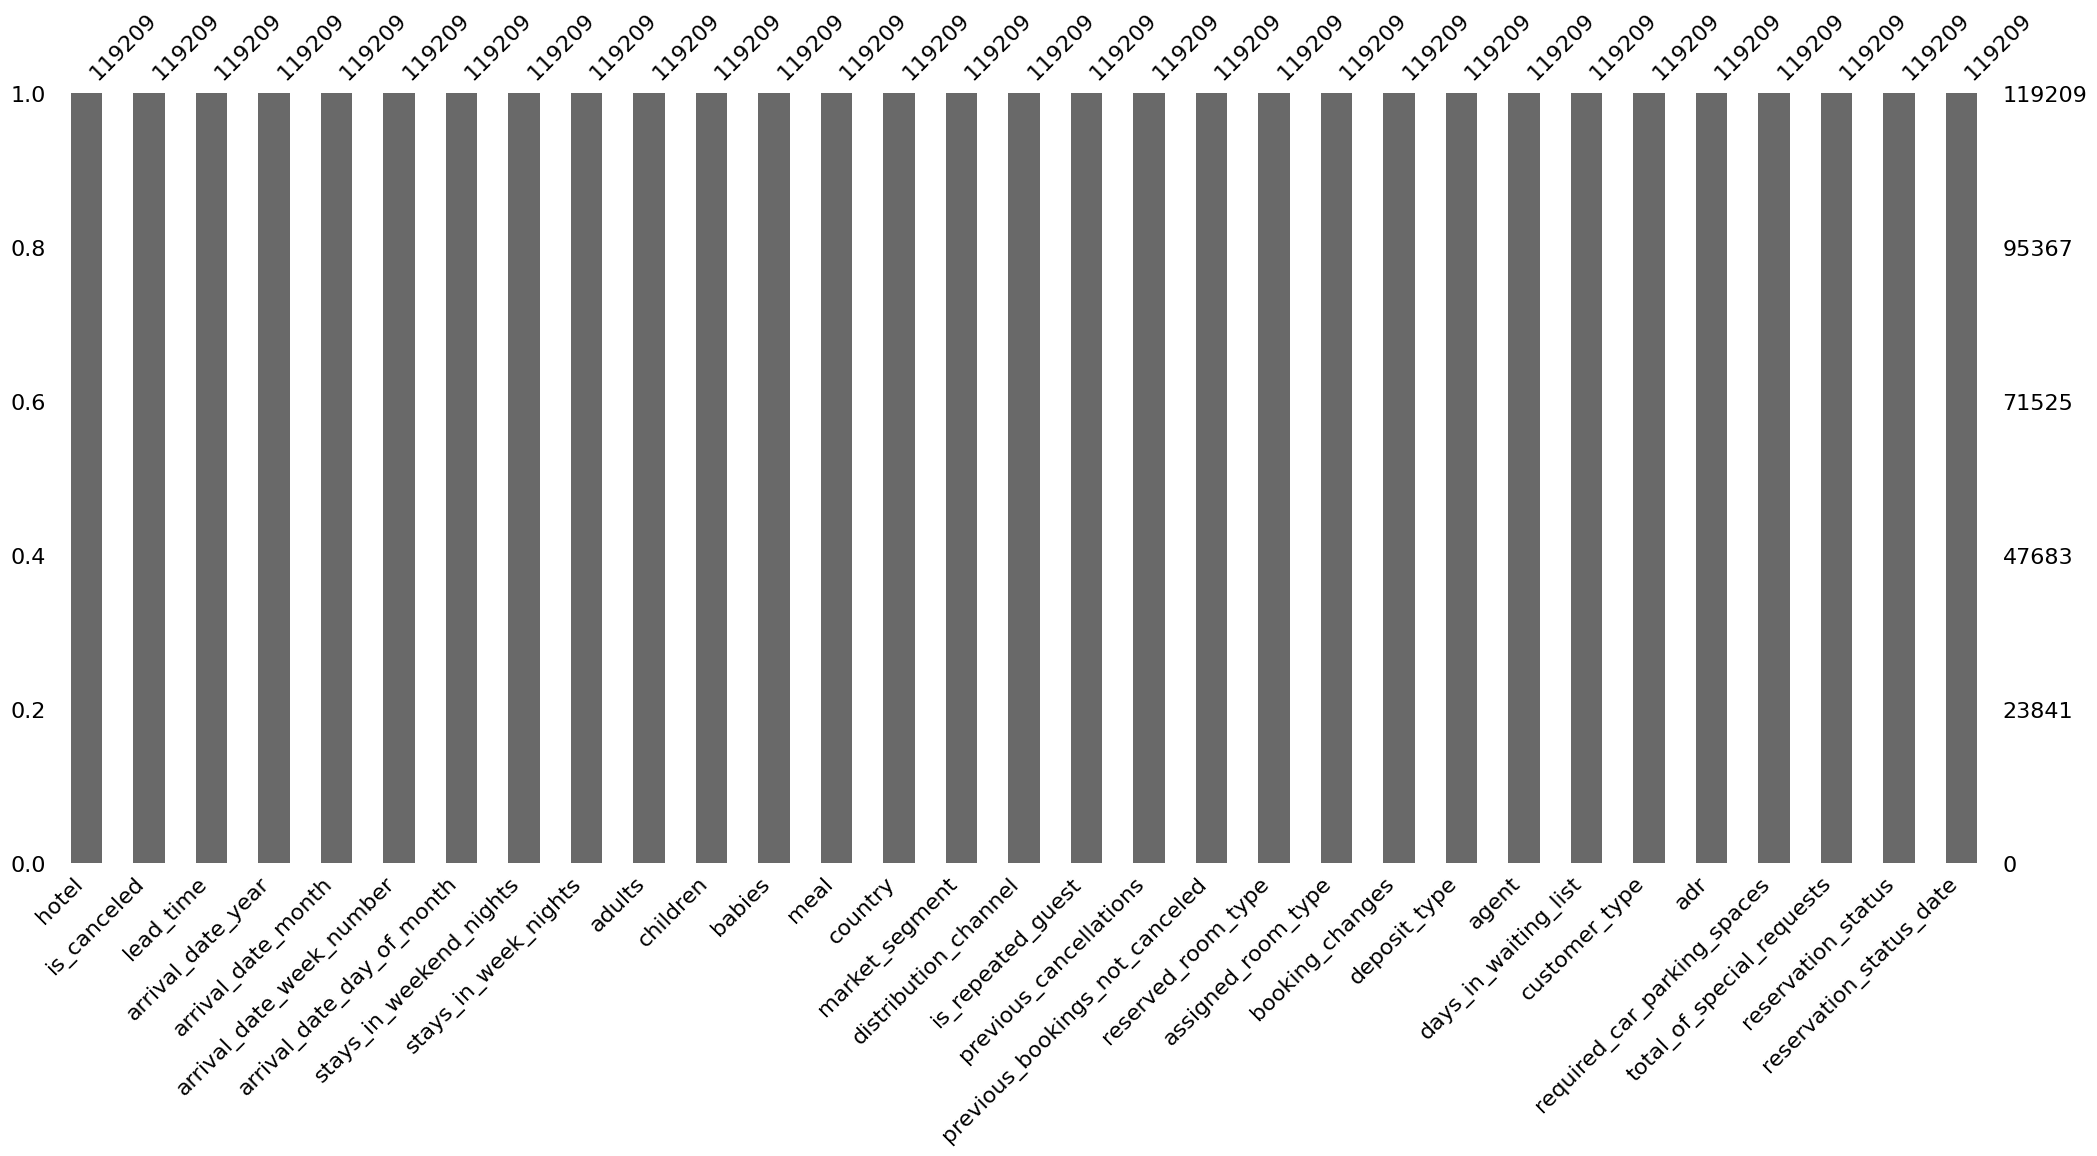

In [44]:
import missingno as msno

msno.bar(df)
plt.show()

There are no missing values in the dataset anymore.

### Duplicate Data Detection

In [45]:
# counting strict duplicated rows ('first' is the default value, excludes the first occurrence and marks the rest as True)
df.duplicated(keep='first').sum()

32013

Strict duplicates are typically system errors, but identifying repeated rows and their patterns can still provide valuable insights. For example, it can help IT teams track why certain rows are entered multiple times, pinpoint the cause of this error, and prevent it from happening in the future. Additionally, analyzing patterns of repetition might reveal issues in the data collection or entry processes and help improve data validation procedures.

By recognizing and addressing these causes, the team can take steps to prevent future duplicates, improve data accuracy, and ensure the data collection or entry processes are functioning correctly. Essentially, even system errors (duplicates) can offer insights into how to optimize and maintain better data quality.

In [46]:
# Finding duplicated rows
duplicates = df[df.duplicated(keep='first')] # keep=False shows all duplicates, keep='first' excludes the first occurrence
columns_list = duplicates.columns.tolist()

# Counting how many times each duplicated row is repeated
duplicate_counts = duplicates.groupby(columns_list).size().reset_index(name='count')
duplicate_counts = duplicate_counts.sort_values(by='count', ascending=False)

# Showing the rows and their respective counts
duplicate_counts[:3]

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,count
5401,City Hotel,1,277,2016,November,46,7,1,2,2,...,Non Refund,-1,0,Transient,100.0,0,0,Canceled,2016-04-04,179
4177,City Hotel,1,68,2016,February,8,17,0,2,2,...,Non Refund,37.0,0,Transient,75.0,0,0,Canceled,2016-01-06,149
5073,City Hotel,1,188,2016,June,25,15,0,2,1,...,Non Refund,119.0,39,Transient,130.0,0,0,Canceled,2016-01-18,108


In [47]:
# keeping the first occurrence and drop the subsequent repetitions
df = df.drop_duplicates(keep='first')

### Validating Data Types

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 87196 entries, 13803 to 30829
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           87196 non-null  object 
 1   is_canceled                     87196 non-null  int64  
 2   lead_time                       87196 non-null  int64  
 3   arrival_date_year               87196 non-null  int64  
 4   arrival_date_month              87196 non-null  object 
 5   arrival_date_week_number        87196 non-null  int64  
 6   arrival_date_day_of_month       87196 non-null  int64  
 7   stays_in_weekend_nights         87196 non-null  int64  
 8   stays_in_week_nights            87196 non-null  int64  
 9   adults                          87196 non-null  int64  
 10  children                        87196 non-null  float64
 11  babies                          87196 non-null  int64  
 12  meal                            8

- **reservation_status_date:** object – This should be converted to datetime64[ns] for proper date handling and time-based analysis.
- **children:** float64 – int64 is more appropriate, as it represents a count and should not allow decimals.
- **is_canceled** and  **is_repeated_guest** int64 - They are better represented as an object type as they show True/False binary values.
- **agent** int64 - agent represents the agent IDs which are identifiers, and storing them as objects allows for better clarity in understanding them as distinct entities rather than numeric data.

In [49]:
# Converting reservation_status_date to datetime64[ns]
df['reservation_status_date'] = pd.to_datetime(df['reservation_status_date'])

# Converting children to int64 (we already handled missing values)
df['children'] = df['children'].astype('int64')

df['agent'] = df['agent'].astype('object')

# Converting is_canceled to object 
df["is_canceled"] = df['is_canceled'].astype('object')

# Converting is_repeated_guest to object 
df["is_repeated_guest"] = df['is_repeated_guest'].astype('object')

# Converting specified columns to category
#columns_to_category = ['meal', 'country', 'distribution_channel','reserved_room_type', 'assigned_room_type', 'deposit_type', 'customer_type', 'reservation_status', 'market_segment', 'arrival_date_month', 'is_canceled', 'is_repeated_guest']

#df[columns_to_category] = df[columns_to_category].apply(lambda x: x.astype('category'))

Introducing a unique identifier for the dataset as booking_id:

In [50]:
df['booking_id'] = df.index  # Using the row index as a unique identifier

### Outlier Detection

<span style="font-size: 18px;">Visual display

In [51]:
df_boxplot = df.drop(columns=['booking_id', 'reservation_status_date', 'agent'])

# Creating two empty lists to store numerical and categorical variables.
cat_vars = []
num_vars = []

for column_name in df_boxplot.columns:
    if df_boxplot[column_name].dtype in ['object', 'category']:        
        cat_vars.append(column_name)
    else:
        num_vars.append(column_name)

print(f"Number of Categorical columns: {len(cat_vars)}")
print(f"Number of Numerical columns: {len(num_vars)}\n")

print(f"Categorical columns: {cat_vars}\n")
print(f"Numerical columns: {num_vars}")

Number of Categorical columns: 13
Number of Numerical columns: 16

Categorical columns: ['hotel', 'is_canceled', 'arrival_date_month', 'meal', 'country', 'market_segment', 'distribution_channel', 'is_repeated_guest', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'customer_type', 'reservation_status']

Numerical columns: ['lead_time', 'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'adr', 'required_car_parking_spaces', 'total_of_special_requests']


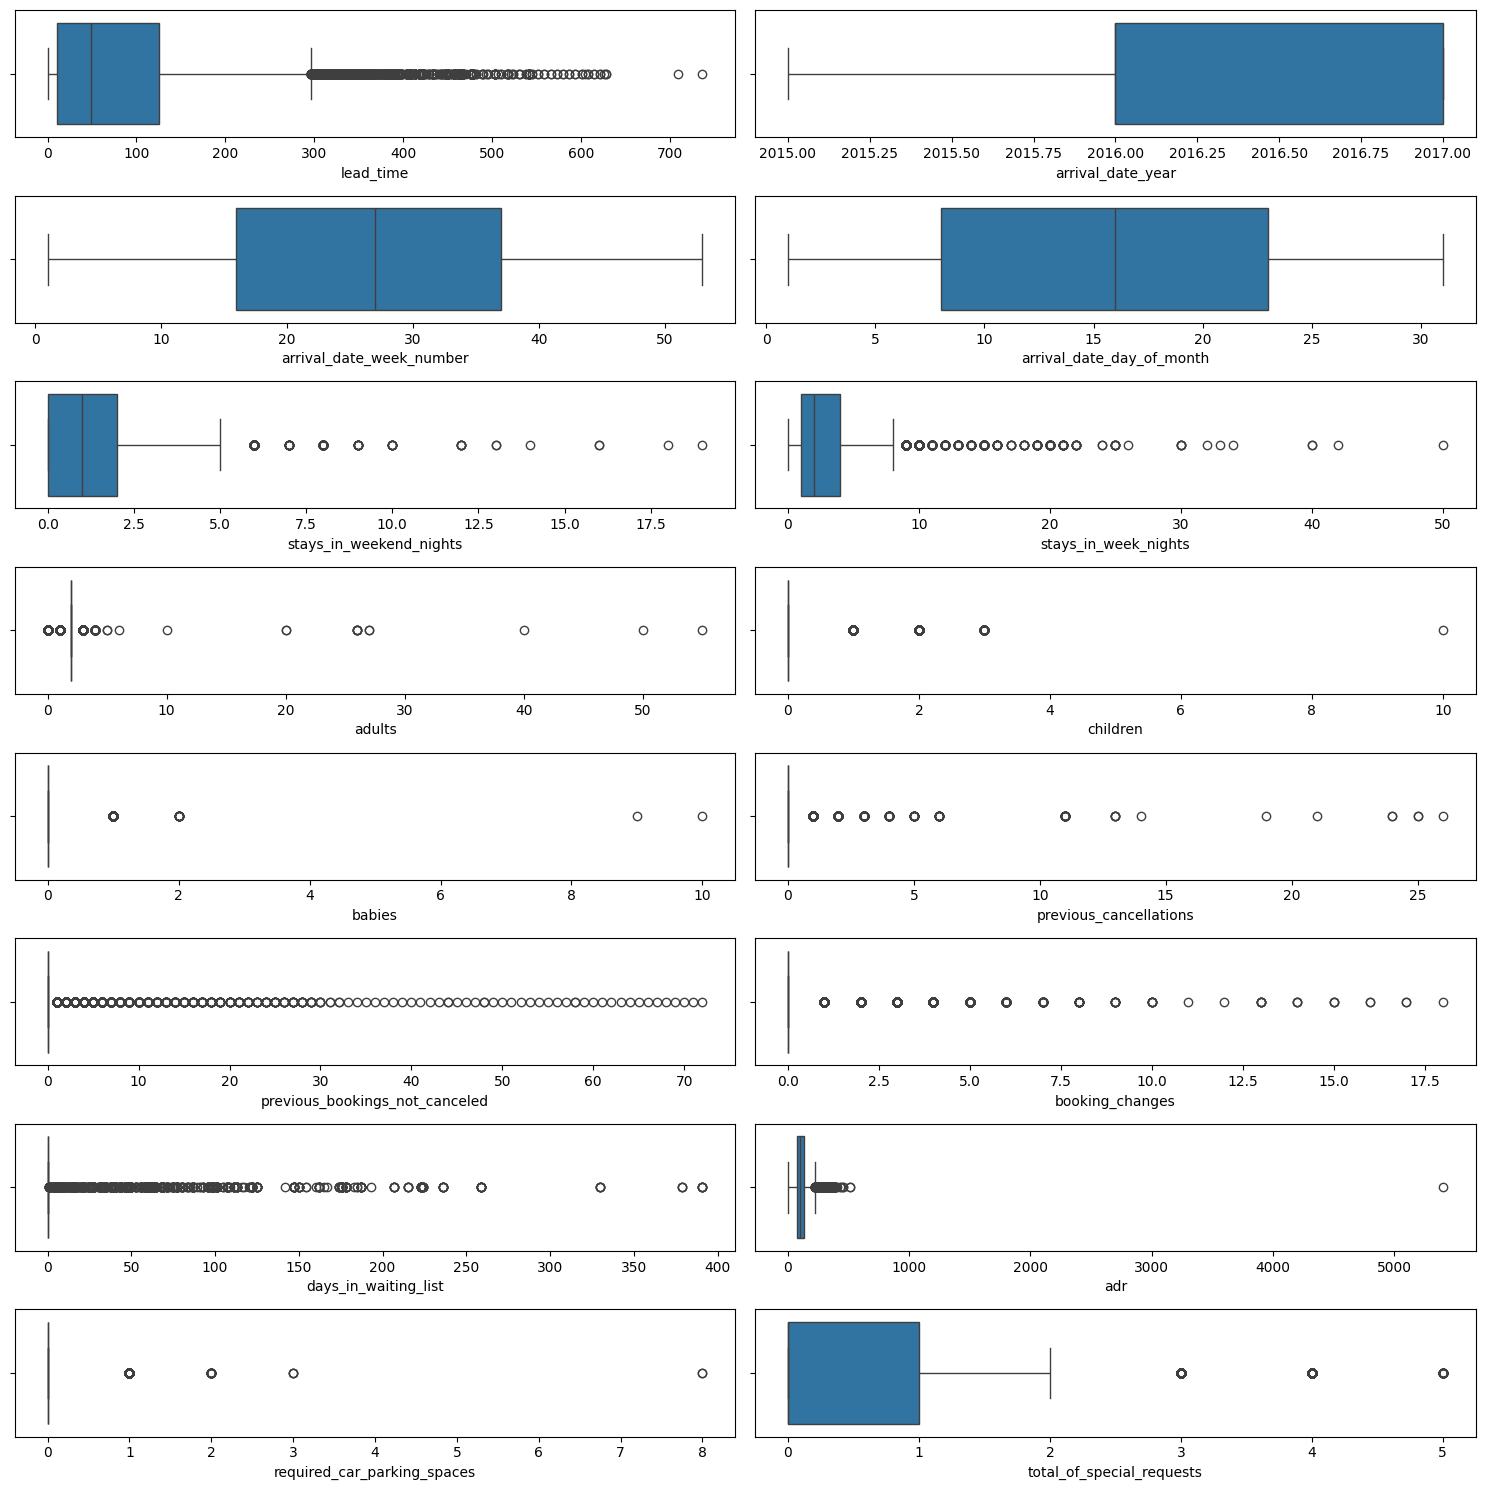

In [52]:
# Setting the figure size
fig, axs = plt.subplots(nrows=8, ncols=2, figsize=(15, 15))
axs = axs.flatten()

# creating box plot for numerical columns
for i, var in enumerate(num_vars):
    sns.boxplot(x=var, data=df, ax=axs[i])
    
    # Labeling axis explicitly
    axs[i].set_xlabel(var)
    #axs[i].set_ylabel('Values')

fig.tight_layout() 
plt.show()

<span style="font-size: 18px;">**Explanation:**

Box plots highlight the outliers for the following columns:

'lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'adr', 'required_car_parking_spaces'

So far, we have visually identified the columns with outliers. Next, we will examine the distribution of these columns. 
If they follow a normal distribution, we can safely use the z-score to detect specific outliers. 

We will check the distribution both visually and using statistical tests.

<span style="font-size: 18px;">Histograms

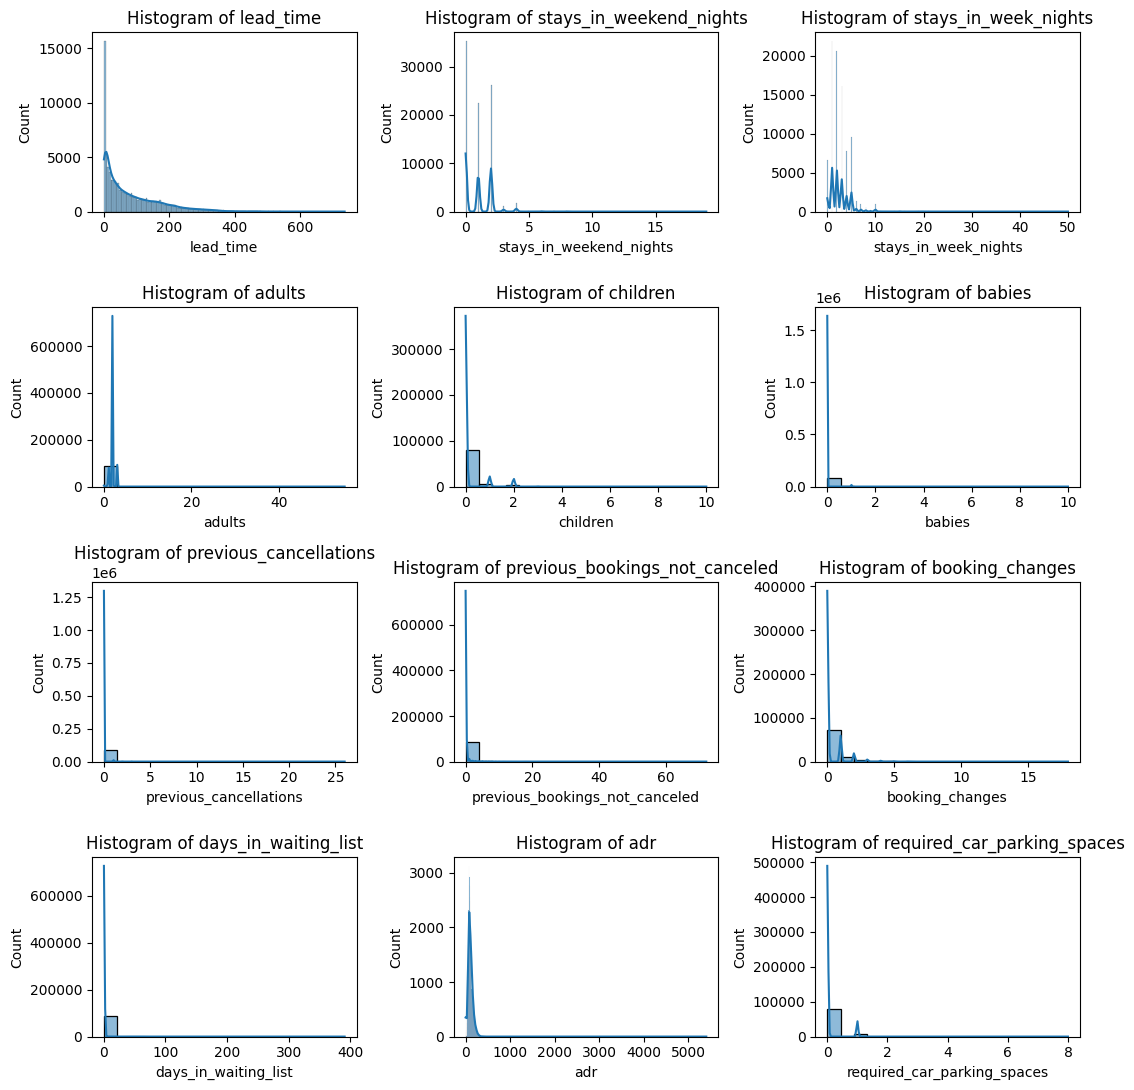

In [53]:
# The columns with potential outliers 
columns_to_plot = ['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies',\
'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'adr', \
'required_car_parking_spaces']

# Calculating the number of subplots needed
n_plots = len(columns_to_plot)

# Creating the subplots
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(11, 11))  
axs = axs.flatten()  

# Creating histograms for each column
for i, col in enumerate(columns_to_plot):
    sns.histplot(df[col], kde=True, ax=axs[i])  
    axs[i].set_title(f'Histogram of {col}')  

# Hiding the last empty subplot if there are only 7 columns
for i in range(n_plots, len(axs)):
    axs[i].axis("off")

plt.tight_layout()  
plt.show()


<span style="font-size: 18px;">Shapiro-Wilk Test statistic

In [54]:
# We use Shapiro-Wilk Test statistic for normality check 
from scipy.stats import shapiro

dict_normal_dist = {}
for col in columns_to_plot:
    stat, p_value = shapiro(df[col].dropna())  # Drop NaN values to avoid errors
    if p_value > 0.05:
        dict_normal_dist[col] = "Normal"
    else:
        dict_normal_dist[col] = "Not Normal"

# Printing columns that are normally distributed
normal_columns = [col for col, status in dict_normal_dist.items() if status == "Normal"]

if normal_columns:
    print(f"Columns that are normally distributed: {normal_columns}\n")
else:
    print("No columns are normally distributed.\n")

No columns are normally distributed.



<span style="font-size: 18px;">**Outlier Detection for Non-normally Distributed Data**

Since the data is not normally distributed, the standard Z-score method does not work well for outlier detection. 
Instead, we should reply on alternative methods suitable for non-normal distributions. We have a wide variety of options. Here, we choose the Percentile-Based method to detect extreme outliers with a high confidence interval (99.9%).

Definition of 99.9% Confidence Interval (Percentile-Based): In this method, the 99.9th percentile is used as the upper bound. Any value above this upper bound is considered an outlier.

Important Note: In this dataset, the columns we are analyzing contain non-negative values, with 0 being considered normal. Therefore, we do not check for the lower bound and focus only on identifying data points that exceed the upper bound.

In [55]:
# Defining upper bound for each column 
upper_bound = df[columns_to_plot].quantile(0.999)  # 99.9th percentile

# Creating a dictionary to store outlier values for each column
outliers_dict = {}

for column in columns_to_plot:
    # Filtering the outliers for each column
    outliers = df[df[column] > upper_bound[column]]
    
    # Adding the outliers as a list to the dictionary
    outliers_dict[column] = outliers[column].tolist()

# Printing the outlier lists for each column
for column, outliers_list in outliers_dict.items():
    print(f"{column} outliers: {outliers_list[:5]}... \n")  # Displaying the first 5 outliers 
    #print(f"{column} outliers:\n {outliers_list}\n")    # Displaying the full list

lead_time outliers: [566, 566, 545, 545, 552]... 

stays_in_weekend_nights outliers: [8, 8, 16, 8, 8]... 

stays_in_week_nights outliers: [20, 21, 40, 22, 21]... 

adults outliers: [4, 4, 4, 4, 4]... 

children outliers: [3, 3, 3, 3, 3]... 

babies outliers: [2, 10, 2, 2, 2]... 

previous_cancellations outliers: [6, 6, 6, 6, 11]... 

previous_bookings_not_canceled outliers: [58, 59, 60, 61, 26]... 

booking_changes outliers: [7, 7, 10, 7, 7]... 

days_in_waiting_list outliers: [185, 185, 223, 187, 187]... 

adr outliers: [5400.0, 336.0, 510.0, 353.0, 342.29]... 

required_car_parking_spaces outliers: [2, 2, 2, 2, 2]... 



<span style="font-size: 16px;">**Observations**

Many of the flagged outliers seem plausible if the dataset includes large group bookings, long-term stays, or special events.
However, some of these outliers (e.g., extremely high values for children, babies, and parking spaces) likely indicate data issues that should be verified.
It's essential to evaluate the context in which these outliers occur, as they may represent rare but valid cases or could signal errors in data entry or processing.

<span style="font-size: 16px;">**Next steps**

- Verify: We should cross-check these outliers with the raw data to ensure they are legitimate.
- Contextual Review: Some outliers (e.g., bookings with very high numbers of children or babies) may need further investigation as they might represent data entry issues.
- Impute or Remove: Depending on the analysis, we may want to either impute or remove some of these outliers if they are determined to be errors or irrelevant for our analysis.

<span style="font-size: 16px;">**Cross-checking with the original dataset (whether the outliers are part of group bookings)**

In [56]:
# First, let's combine the outliers for each column into a single list
outliers_combined = pd.concat([df[df[column] > upper_bound[column]] for column in columns_to_plot])

# Checking if these outliers belong to the 'Group' customer type
outliers_group = outliers_combined[outliers_combined['customer_type'] == 'Group']

# Displaying the outliers that belong to the 'Group' customer type
#print("Outliers associated with 'Group' customer type:\n", outliers_group)

outliers_group.shape

(17, 32)

Group bookings often involve larger volumes and specific booking behaviors that may not apply to individual bookings. These group-related outliers could represent legitimate trends or patterns, making them valuable for analysis. That's why we decided to keep the outliers that are identified as part of group bookings.

For the rest of the outliers, we do not have access to further information, such as data entry practices, which would help determine whether these values are errors or legitimate extreme values. Therefore, we decided to remove the remaining outliers to ensure the integrity of the analysis. It's worth mentioning again that we considered the data above 99.9 percentile as outliers which means extreme cases outside of 99.9% confidence interval.

Now, to remove all outliers except the ones associated with "Group" customer type, we can filter out the general outliers (those exceeding the upper bound) and then keep only the ones that belong to the "Group" category.

In [57]:
# Removing the outliers for all columns
outliers_removed = df[~df.index.isin(outliers_combined.index)]  # Removing all outliers

# Identifying the outliers related to 'Group' customer type
group_outliers = outliers_combined[outliers_combined['customer_type'] == 'Group']

# Combining the non-outlier data with the 'Group' outliers
df = pd.concat([outliers_removed, group_outliers])

# Displaying the final DataFrame with outliers removed except those associated with 'Group'
# print(f "Final DataFrame (with group outliers retained): {final_df}")
df.shape

(86482, 32)

Final check for any remaining extreme values in the data that are illogical or lack a valid explanation.

We redo the same steps we did before to extract the outliers with 99.9% confidence interval.

In [58]:
# Defining upper bound for each column 
upper_bound = df[columns_to_plot].quantile(0.999)  # 99.9th percentile

# Creating a dictionary to store outlier values for each column
outliers_dict = {}

for column in columns_to_plot:
    # Filtering the outliers for each column
    outliers = df[df[column] > upper_bound[column]]
    
    # Adding the outliers as a list to the dictionary
    outliers_dict[column] = outliers[column].tolist()

# Printing the outlier lists for each column
for column, outliers_list in outliers_dict.items():
    #print(f"{column} outliers: {outliers_list[:5]}... \n")  # Displaying the first 5 outliers 
    print(f"{column} outliers:\n {outliers_list}\n")    # Displaying the full list

lead_time outliers:
 [468, 468, 468, 468, 468, 468, 468, 471, 462, 468, 468, 468, 468, 468, 468, 465, 462, 462, 462, 464, 465, 465, 465, 465, 468, 468, 468, 467, 479, 476, 476, 476, 468, 468, 468, 468, 465, 465, 464, 464, 465, 465, 465, 465, 464, 465, 465, 463, 465, 462, 462, 462, 462, 462, 462, 462, 462, 476, 476, 476, 476, 468, 479, 479, 479, 479, 478, 479, 479, 479, 479, 479, 479, 478, 478, 458, 460, 460, 475, 468, 468, 475, 461, 461]

stays_in_weekend_nights outliers:
 [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]

stays_in_week_nights outliers:
 [16, 16, 17, 17, 18, 16, 18, 16, 19, 16, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 16, 16, 19, 17, 18, 17, 16, 16, 16, 18]

adults outliers:
 [27, 27, 26, 26, 26, 50, 40, 26, 5, 20, 10, 5, 6, 20, 55, 26]

children outliers:
 [3]

babies outliers:
 []

previous_cancellations outliers:
 [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3,

We observe that there are no illogically extreme values in these columns anymore. 

<span style="font-size: 21px;">**Handling Outliers in Categorical Features**

1. Identify Categorical Features: 
First, we need to identify which columns are categorical. These are typically of types object or category in pandas.

2. Check Value Counts for Categorical Features: 
We’ll check the unique value counts for each categorical feature. If any category has a very low count (such as just a few observations), we’ll consider it as a potential outlier.

3. Define Outlier Criteria: 
We need a clear strategy for what counts as an outlier for categorical data. A typical criterion is:
Categories with fewer than a certain threshold of observations (e.g., 1% of the dataset size) might be considered outliers.

4. Handle Outliers in Categorical Features: 

- Option 1: We’ll group rare categories into a single 0 category. (None of the categories in any of the columns is called 0)
- - Option 2: Alternatively, we can remove rows with extremely rare categories. (We stick with the first option here.)

5. Check the Distribution of Categorical Features: 
After handling outliers, it's a good idea to check the distribution again to ensure the data is balanced and meaningful.

**NOTE**: We identify outliers and make sure the transformed features retain their original data types.

In [59]:
threshold = 0.01  # Categories with fewer than 1% of total records will be considered outliers

# Identifying Categorical Features
categorical_features = [col for col in df.columns if df[col].dtype in ['object', 'category']]

# Removing 'reservation_status_date' from the list if it exists
# This feature is supposed to have datetime format 
# From EDA, we know deposit_type, categories are valid
if 'reservation_status_date' in categorical_features:
    categorical_features.remove('reservation_status_date')
if 'deposit_type' in categorical_features:
    categorical_features.remove('deposit_type')

# Checking Value Counts for Categorical Features
for col in categorical_features:
    print(f"Value counts for {col}:")
    print(df[col].value_counts())
    print("-" * 50)

# Handling Categorical Outliers and Replacing with Integer Code
for col in categorical_features:
    value_counts = df[col].value_counts(normalize=True)  # Getting the proportions of each category
    rare_categories = value_counts[value_counts < threshold].index.tolist()  # Categories with frequency below the threshold
    
    # Replacing rare categories with 0
    df[col] = df[col].apply(lambda x: 0 if x in rare_categories else x)
    df[col] = df[col].astype('object')  # Ensuring the column is of type 'object' for string columns

# Now, df has categorical features handled with outliers replaced by '0' 
# and column types are adjusted for SQL insertion.

print("////" * 30)
print("\\\\\\\\" * 30)

# Checking the New Distribution of Categorical Features
for col in categorical_features:
    print(f"Value counts for {col} after handling outliers:")
    print(df[col].value_counts())
    print("-" * 50)

Value counts for hotel:
hotel
City Hotel      52834
Resort Hotel    33648
Name: count, dtype: int64
--------------------------------------------------
Value counts for is_canceled:
is_canceled
0    62696
1    23786
Name: count, dtype: int64
--------------------------------------------------
Value counts for arrival_date_month:
arrival_date_month
August       11104
July          9959
May           8272
April         7849
June          7727
March         7445
October       6886
September     6603
February      6027
December      5063
November      4940
January       4607
Name: count, dtype: int64
--------------------------------------------------
Value counts for meal:
meal
BB           67346
SC            9366
HB            8939
Undefined      481
FB             350
Name: count, dtype: int64
--------------------------------------------------
Value counts for country:
country
PRT    27398
GBR    10350
FRA     8783
ESP     7207
DEU     5364
       ...  
UMI        1
NIC        1
BDI      


<span style="font-size: 18px;">**Results of Outlier Detection in Categorical Features**

Outliers were detected in the following features and grouped under a category named "Other" within each feature: 

'meal', 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'agent', and 'customer_type'.


<span style="font-size: 21px;">**Summary of Data Cleaning & Preparation**

Data cleaning & preparation involved several critical steps to ensure the dataset's accuracy and integrity.

We assessed and corrected any inconsistencies in the data, categorizing them into three groups: **Critical, Inconsistency, and Anomaly detection**. We then addressed these issues based on their importance level and overall business logic. Missing values were handled by either removing or imputing them, depending on the context. To further refine the dataset, we detected and removed any strict duplicate records to ensure uniqueness and accuracy. Lastly, we identified and addressed potential outliers to prevent them from skewing the analysis, ensuring the dataset was clean and ready for further exploration.

In [60]:
# Creating a backup copy of the processed DataFrame
df_backup = df.copy()

In [62]:
df.to_csv('cleaned_and_prepared_data.csv', index=False)

## Inserting Processed Data into Database

After the data cleaning process is complete, the processed data is inserted into the database. This step ensures that the preprocessed and cleaned data is readily accessible through PostgreSQL for further analysis and use.

### Creating the Database

In [523]:
import psycopg2
import config  # Importing the configuration file for database credentials

# Step 1: Connecting to the default PostgreSQL database to create the new database
conn = psycopg2.connect(
    dbname="postgres",  # Default database to connect to
    user=config.DB_USER,
    password=config.DB_PASSWORD,
    host=config.DB_HOST,
    port=config.DB_PORT
)
conn.autocommit = True  # Enabling autocommit so changes are applied automatically
cursor = conn.cursor()

# Step 2: Creating the 'hotel_demand_database' if it does not exist
cursor.execute("SELECT 1 FROM pg_catalog.pg_database WHERE datname = %s", ('hotel_demand_database',))
exists = cursor.fetchone()
if not exists:
    cursor.execute('CREATE DATABASE hotel_demand_database;')
    print("Database 'hotel_demand_database' created successfully.")
else:
    print("Database 'hotel_demand_database' already exists.")

conn.close()  # Closing the initial connection to 'postgres'

Database 'hotel_demand_database' already exists.


### Connecting to PostgreSQL

In [524]:
# Step 1: Connecting to the 'hotel_demand_database' using credentials from config.py
conn = psycopg2.connect(
    dbname=config.DB_NAME,
    user=config.DB_USER,
    password=config.DB_PASSWORD,
    host=config.DB_HOST,
    port=config.DB_PORT
)
conn.autocommit = True  # Enabling autocommit so changes are applied automatically
cursor = conn.cursor()

In [540]:
# Preferred data types in SQL table 

df["is_canceled"] = df['is_canceled'].astype('int64')
df["is_repeated_guest"] = df['is_repeated_guest'].astype('int64')
df["agent"] = df['agent'].astype('int64')

### Creating the Table

In [541]:
# Step 2: Creating the table if it does not exist
create_table_query = """CREATE TABLE IF NOT EXISTS hotel_demand_adr (
    hotel VARCHAR(255),  
    lead_time INT,
    arrival_date_year INT,
    arrival_date_month VARCHAR(20),
    arrival_date_week_number INT,
    arrival_date_day_of_month INT,
    stays_in_weekend_nights INT,
    stays_in_week_nights INT,
    adults INT,
    children INT,
    babies INT,
    meal VARCHAR(255),
    country VARCHAR(255),
    market_segment VARCHAR(50),
    distribution_channel VARCHAR(50),
    is_repeated_guest INT,
    previous_cancellations INT,
    previous_bookings_not_canceled INT,
    reserved_room_type VARCHAR(50),
    assigned_room_type VARCHAR(50),
    booking_changes INT,
    deposit_type VARCHAR(50),
    agent VARCHAR(50),  
    days_in_waiting_list INT,
    customer_type VARCHAR(50),
    adr FLOAT,
    required_car_parking_spaces INT,
    total_of_special_requests INT,
    reservation_status VARCHAR(50),
    reservation_status_date TIMESTAMP,  
    booking_id INT
);"""

# Dropping the existing data in the table 
# cursor.execute("DROP TABLE IF EXISTS hotel_demand_adr;") # Executing Table Creation
cursor.execute(create_table_query)
conn.commit()

# Dropping the existing data in the table
cursor.execute("DELETE FROM hotel_demand_adr;")
conn.commit()

In [538]:
# Checking table schema
#\d hotel_demand_adr;

### Inserting Data into the Table

In [542]:
# Step 4: Insert the processed DataFrame into the table
for _, row in df.iterrows():
    # Explicitly converting problematic columns to the correct types 
    row['hotel'] = str(row['hotel'])  # Ensuring 'hotel' is a string
    row['agent'] = int(row['agent'])  # Ensuring 'agent' is an int 
    row["is_canceled"] = int(row['is_canceled']) # Ensuring 'is_canceled' is an int 
    row["is_repeated_guest"] = int(row['is_repeated_guest']) # Ensuring 'is_repeated_guest' is an int
    
    # Convert row to a tuple
    values = tuple(row)
    
    # Explicitly define the column names to avoid order issues
    columns = [
        'hotel', 'is_canceled', 'lead_time', 'arrival_date_year', 'arrival_date_month',
        'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights',
        'stays_in_week_nights', 'adults', 'children', 'babies', 'meal', 'country',
        'market_segment', 'distribution_channel', 'is_repeated_guest', 'previous_cancellations',
        'previous_bookings_not_canceled', 'reserved_room_type', 'assigned_room_type',
        'booking_changes', 'deposit_type', 'agent', 'days_in_waiting_list', 'customer_type',
        'adr', 'required_car_parking_spaces', 'total_of_special_requests', 'reservation_status',
        'reservation_status_date', 'booking_id'
    ]
    
    # Creating the insert query with the column names
    placeholders = ", ".join(["%s"] * len(columns))
    insert_query = f"INSERT INTO hotel_demand_adr ({', '.join(columns)}) VALUES ({placeholders})"
    
    # Executing the insert query
    cursor.execute(insert_query, values)

conn.commit()  # Committing changes to the database
print("Processed data has been written to the database.")

Processed data has been written to the database.


The dataset is ready for analysis.

## Exploratory Data Analysis (EDA)  

We conduct an in-depth exploratory data analysis (EDA), with a primary focus on cancellations and the Average Daily Rate (ADR). Our analysis aims to thoroughly address the following critical questions, extracting insights and providing business recommendations:

- **Question:** How does the cancellation rate vary by market segment?
- **Question:** What is the distribution of lead time, and how does it impact cancellations?
- **Question:** What is the correlation matrix between all numerical columns in the dataset, and what does it reveal about the relationships between these variables?
- **Question:** How do the categorical features in the dataset (e.g., hotel, meal, country, market_segment, reservation_status) correlate with key variables such as adr and is_canceled?
- **Question**: How does the average daily rate (ADR) fluctuate over time, and what seasonal trends or anomalies can be observed?

By addressing these questions, we gain a comprehensive understanding of how various factors contribute to cancellations and ADR, providing valuable insights for decision-making and strategy development.

### Cancellation Rate vs Market Segment

<span style="font-size: 20px;">**Question:** How does the cancellation rate vary by market segment?

Understanding cancellation patterns can help tailor marketing and operational strategies based on the type of customers.

In [ ]:
df = df_processed.copy()

In [310]:
# 'Group by' market segment and calculate the cancellation rate
cancellation_rates = df.groupby('market_segment')['is_canceled'].mean().reset_index()
cancellation_rates["count"] = df['market_segment'].value_counts().values
cancellation_rates["percentage_of_Total"] = round(cancellation_rates["count"]/cancellation_rates["count"].sum()*100,2)

# Renaming column for clarity
cancellation_rates.rename(columns={'is_canceled': 'cancellation_rate'}, inplace=True)

# Sort_values for better visualization
cancellation_rates = cancellation_rates.sort_values(by='cancellation_rate', ascending=False)

# Displaying numerical values
print(cancellation_rates)

  market_segment cancellation_rate  count  percentage_of_Total
7      Undefined               1.0      2                 0.00
6      Online TA          0.353686    226                 0.26
4         Groups          0.263981   4017                 4.67
0       Aviation          0.199115  51181                59.51
3         Direct          0.146881   4667                 5.43
5  Offline TA/TO          0.145952    646                 0.75
1  Complementary          0.126935  13662                15.88
2      Corporate          0.122479  11608                13.50


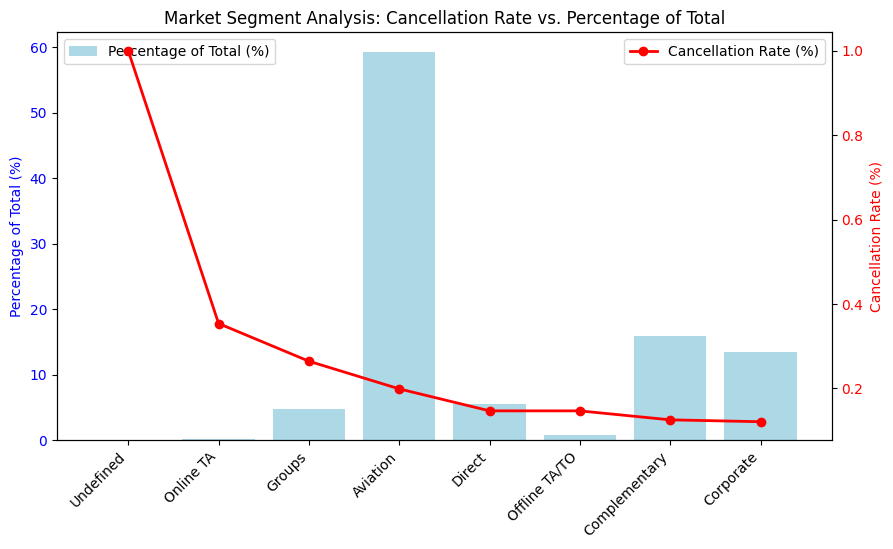

In [311]:
market_segments = [
    "Undefined", "Online TA", "Groups", "Aviation", "Direct",
    "Offline TA/TO", "Complementary", "Corporate"
]
cancellation_rates = [1.0, 0.35398, 0.264632, 0.199115, 0.147061, 0.146995, 0.12574, 0.121286]
percentage_of_total = [0.00, 0.26, 4.75, 59.31, 5.53, 0.78, 15.89, 13.48]

fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot for percentage of total bookings
ax1.bar(market_segments, percentage_of_total, color='lightblue', label="Percentage of Total (%)")
ax1.set_ylabel("Percentage of Total (%)", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Second y-axis for cancellation rate
ax2 = ax1.twinx()
ax2.plot(market_segments, cancellation_rates, color='red', marker='o', linestyle='-', linewidth=2, label="Cancellation Rate (%)")
ax2.set_ylabel("Cancellation Rate (%)", color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Titles and Labels
plt.title("Market Segment Analysis: Cancellation Rate vs. Percentage of Total")
fig.autofmt_xdate(rotation=45)  # Rotating x-axis labels for readability

# Legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

<span style="font-size: 18px;">**Key Insights:**

- Aviation dominates bookings (59.3%) but has a moderate cancellation rate (19.9%), suggesting relatively stable reservations.
- Complementary (15.9%) and Corporate (13.5%) bookings are the next largest, with low cancellation rates (~12%), indicating reliability.
- Online TA has the highest valid cancellation rate (35.4%) despite a small share (0.26%), likely due to flexible policies.
- Groups (4.75%) have a high cancellation rate (26.5%), reflecting logistical uncertainties.
- Undefined segment (100% cancellations, 0.00% share) suggests data quality issues.

### Impact of Lead Time on Cancellations

<span style="font-size: 20px;">**Question:** What is the distribution of lead time, and how does it impact cancellations?

Longer lead times may have different cancellation behaviors, and understanding them can improve inventory and booking management.

In [ ]:
df = df_processed.copy()

count    86009.000000
mean        78.842005
std         83.552735
min          0.000000
25%         11.000000
50%         49.000000
75%        124.000000
max        457.000000
Name: lead_time, dtype: float64
               count        mean        std  min   25%   50%    75%    max
is_canceled                                                               
0            62355.0   69.342747  79.793700  0.0   7.0  38.0  109.0  457.0
1            23654.0  103.883276  87.949254  0.0  32.0  79.0  157.0  457.0
Correlation between lead_time and is_canceled:
              lead_time  is_canceled
lead_time     1.000000     0.184593
is_canceled   0.184593     1.000000


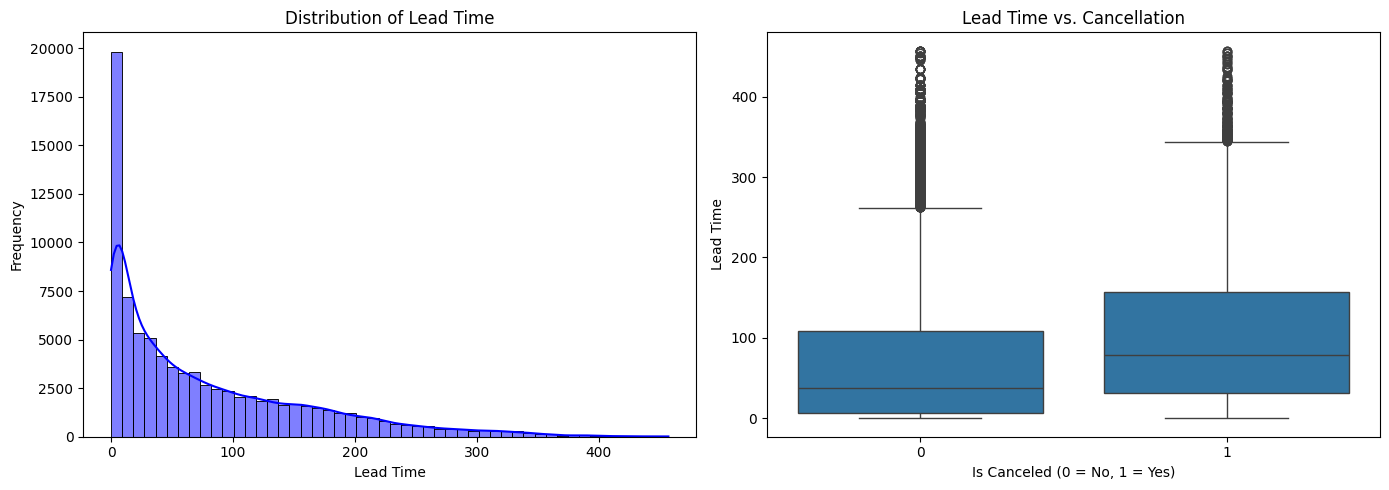

In [312]:
# Summary Statistics
print(df['lead_time'].describe())  # General distribution
print(df.groupby('is_canceled')['lead_time'].describe())  # Canceled vs. Non-canceled

# Correlation Analysis
corr = df[['lead_time', 'is_canceled']].corr()
print("Correlation between lead_time and is_canceled:\n", corr)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram & KDE for lead_time distribution
sns.histplot(df['lead_time'], bins=50, kde=True, ax=axes[0], color='blue')
axes[0].set_title("Distribution of Lead Time")
axes[0].set_xlabel("Lead Time")
axes[0].set_ylabel("Frequency")

# Boxplot: Lead time by cancellation status
sns.boxplot(x=df["is_canceled"], y=df["lead_time"], ax=axes[1])
axes[1].set_title("Lead Time vs. Cancellation")
axes[1].set_xlabel("Is Canceled (0 = No, 1 = Yes)")
axes[1].set_ylabel("Lead Time")

plt.tight_layout()
plt.show()


<span style="font-size: 18px;">**Lead Time for Canceled vs. Non-Canceled Bookings:**

**Non-Canceled (is_canceled = 0):**
Mean: 69.80 days, 
Median: 38.0 days (most non-cancelled bookings occur closer to the check-in date). 
Standard Deviation: 80.73 days (indicating variability).

**Canceled (is_canceled = 1):**
Mean: 104.49 days,
Median: 80.0 days (canceled bookings tend to have longer lead times).
Standard Deviation: 89.06 days (indicating high variability in cancellations).

Canceled bookings tend to have longer lead times on average, suggesting that bookings made well in advance have a higher likelihood of being canceled.

**The correlation coefficient** between lead_time and is_canceled is 0.183, indicating a weak positive linear correlation.
This means that, linearly, while there is a relationship between longer lead times and cancellations, it's not particularly strong. A higher lead time slightly increases the likelihood of cancellation, but the effect is not drastic.

<span style="font-size: 19px;">**Mutual Information Regression**

Let's check the **Non-linear** correlation using **mutual_info_regression:**

In [313]:
from sklearn.feature_selection import mutual_info_regression

# The function mutual_info_regression expects a 2D array (a DataFrame) for the input features, 
# hence df[['lead_time']] (double brackets) is used to pass lead_time as a 2D object.
# the target variable (is_canceled) is 1D, so it's extracted using single brackets as a Series.
mi = mutual_info_regression(df[['lead_time']], df['is_canceled'])
print("Mutual Information:\n", mi[0])

Mutual Information:
 0.03394812820867976


<span style="font-size: 18px;">**Interpretation of the Mutual Information**

The Mutual Information (MI) value of 0.0391 indicates that there is a low amount of shared information between lead_time and is_canceled.

The low MI value suggests that while lead_time has some influence on cancellations, there are likely other stronger predictors or more complex relationships that are affecting cancellations.

This further supports the idea that the correlation between lead_time and is_canceled is weak (as we observed with the Pearson correlation), and other factors may be more important in predicting cancellations.

### Numerical Features Correlation with Key Variables

<span style="font-size: 20px;">**Question:** What is the correlation matrix between all numerical columns in the dataset, and what does it reveal about the relationships between these variables?

In [798]:
df = df_processed.copy()

The correlation matrix accepts numerical features only, so we extract year, month, day, weekday, and weeknumber from the 'year_reservation_status' column.

In [799]:
# the week of the year (weeknumber)
df['reservation_status_week_number'] = df['reservation_status_date'].dt.isocalendar().week.astype(int)

In [800]:
# We extract year, month, week, day info from the year_reservation_status column to feed to corr matrix.

df['reservation_status_year'] = df['reservation_status_date'].dt.year.astype(int)
df['reservation_status_month'] = df['reservation_status_date'].dt.month.astype(int)
df['reservation_status_day_of_month'] = df['reservation_status_date'].dt.day.astype(int) # the day of the month
df['reservation_status_day_of_week'] = df['reservation_status_date'].dt.weekday.astype(int) # the day of the week

In [801]:
# mapping the months to their corresponding numerical values
month_mapping = {month: idx + 1 for idx, month in enumerate(ordered_months)}

# Applying the mapping to 'arrival_date_month'
df['arrival_date_month'] = df['arrival_date_month'].map(month_mapping)

# verifying the converted column
#df['arrival_date_month']

In [802]:
# Let's convert is_canceled back to numerical for the sake of measuring correlation
df["is_canceled"] = df["is_canceled"].astype('int64')

In [803]:
df_corr = df.drop(columns=['booking_id', 'agent'])
numerical_columns = []

for col in df_corr:
    if df_corr[col].dtype in ['int64', 'float64', '']:
        numerical_columns.append(col)

print(f"Number of Numerical columns: {len(numerical_columns)}\n")
print(f"Numerical columns: {numerical_columns}")

Number of Numerical columns: 23

Numerical columns: ['is_canceled', 'lead_time', 'arrival_date_year', 'arrival_date_month', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'adr', 'required_car_parking_spaces', 'total_of_special_requests', 'reservation_status_week_number', 'reservation_status_year', 'reservation_status_month', 'reservation_status_day_of_month', 'reservation_status_day_of_week']


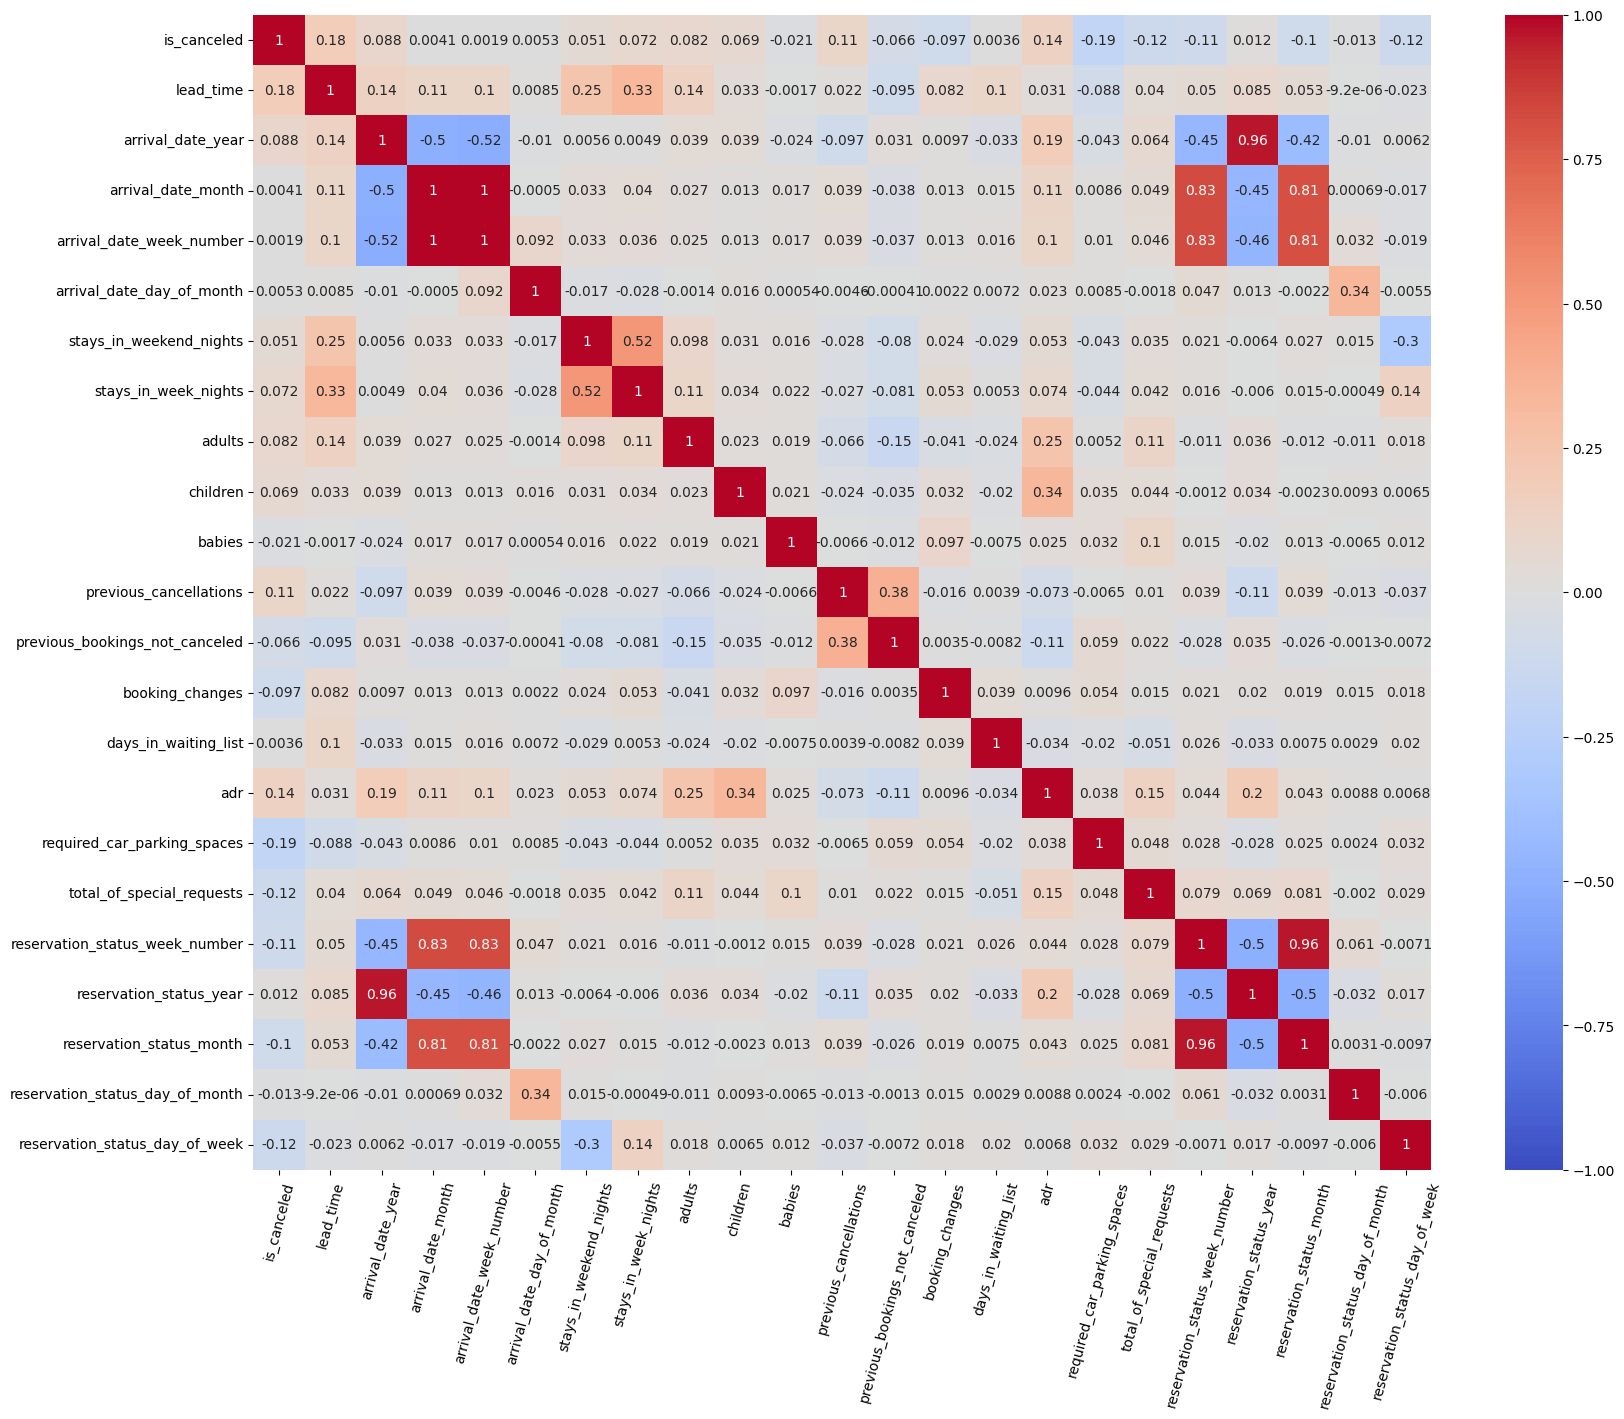

In [804]:
#Cross Correlation Analysis
fig, ax = plt.subplots(figsize=(19,15))

sns.heatmap(df[numerical_columns].corr(), vmin=-1, vmax=1, annot=True, cmap="coolwarm")

plt.xticks(rotation=75)
plt.show()

The extreme correlation between arrival and reservation dates makes sense as they both follow a similar pattern.

In [210]:
correlation_is_cancelled = df[numerical_columns].corr()['is_canceled'].abs().sort_values(ascending = False)

In [211]:
correlation_adr = df[numerical_columns].corr()['adr'].abs().sort_values(ascending = False)

In [212]:
correlation_is_cancelled = correlation_is_cancelled.drop('is_canceled')
correlation_adr = correlation_adr.drop('adr')

In [213]:
correlation_is_cancelled[:3]

required_car_parking_spaces    0.185702
lead_time                      0.183262
adr                            0.136328
Name: is_canceled, dtype: float64

<span style="font-size: 18px;"> **cancellation correlation with other features:**

The correlation values show that factors such as the number of required car parking spaces (0.19), lead time (0.18), and average daily rate (ADR) (0.14) are most strongly correlated with cancellation status. Other moderately correlated variables include the day of the week of the reservation (0.12) and total special requests (0.12). Less influential variables like the arrival date details (day and week number) and the number of children or babies have weaker correlations, indicating a minimal impact on cancellation probability. Overall, there is a notable influence from booking details like parking, lead time, and special requests.

In [214]:
correlation_adr[:3]

children                   0.339276
adults                     0.251688
reservation_status_year    0.196701
Name: adr, dtype: float64

<span style="font-size: 18px;">**Average daily rate correlation with other features:**

The analysis reveals that the Average Daily Rate (ADR) is most strongly influenced by the number of children (0.34) and adults (0.25), indicating that larger groups tend to result in higher ADR. Other notable factors include the year of the reservation (0.20) and the arrival year (0.19), suggesting that pricing trends may vary across years. Special requests also show moderate correlation (0.15) with ADR, while cancellations (0.14) and previous bookings (0.11) have a smaller impact. The correlation with other variables like stay duration, parking spaces, and booking changes is relatively weak, indicating that ADR is less influenced by these factors.

### Categorical Features Correlation with Key Variables

<span style="font-size: 20px;">**Question:** How do the categorical features in the dataset (e.g., hotel, meal, country, market_segment, reservation_status) correlate with key variables such as adr (average daily rate) and is_canceled?

In [ ]:
df = df_processed.copy()

In [236]:
# Extracting categorical features
df_cat = df.drop(columns=['agent', 'booking_id'])
categorical_columns = []

for col in df_cat:
    if df_cat[col].dtype in ['object', 'category']:
        categorical_columns.append(col)

print(f"Number of categorical_columns: {len(categorical_columns)}\n")
print(f"categorical_columns: {categorical_columns}\n")

Number of categorical_columns: 12

categorical_columns: ['hotel', 'arrival_date_month', 'meal', 'country', 'market_segment', 'distribution_channel', 'is_repeated_guest', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'customer_type', 'reservation_status']



<span style="font-size: 20px;"> **Analyzing how mean ADR varies across different categories within each categorical column**

In [235]:
# Initializing an empty dictionary to store results
adr_by_category = {}

# Looping over each categorical column
for col in categorical_columns:
    # Calculating the mean adr for each category in the column
    adr_by_category[col] = df.groupby(col)['adr'].mean().reset_index()

'''
# displaying the results for each categorical column
for col in adr_by_category:
    print(f"Mean adr by {col}:")
    print(adr_by_category[col], "\n")
'''

'\n# displaying the results for each categorical column\nfor col in adr_by_category:\n    print(f"Mean adr by {col}:")\n    print(adr_by_category[col], "\n")\n'

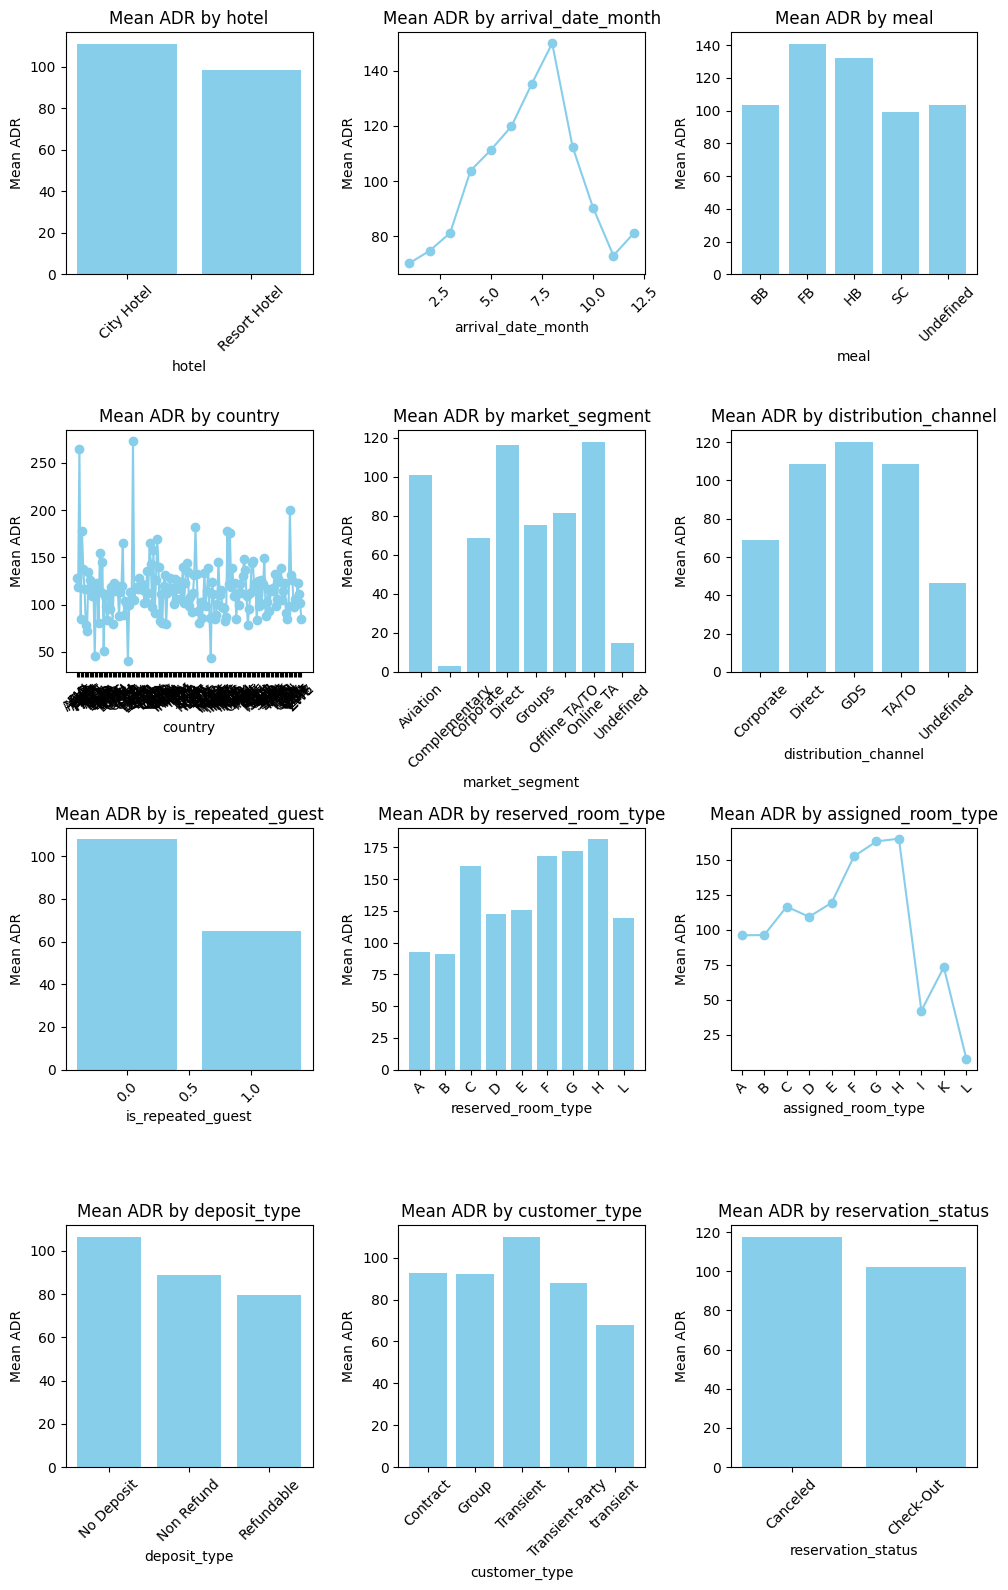

In [233]:
# Initializing an empty dictionary to store the results
adr_by_category = {}

# Looping over each categorical column
for col in categorical_columns:
    # Calculating the mean adr for each category in the column
    adr_by_category[col] = df.groupby(col)['adr'].mean().reset_index()

# Number of columns for the grid layout 
cols = 3

# Calculating the number of rows dynamically based on the number of categorical columns
rows = (len(categorical_columns) + cols - 1) // cols  # Ensures no empty rows

# Creating subplots with the correct number of rows and columns
fig, axes = plt.subplots(rows, cols, figsize=(10, 4 * rows))

# Flattening the axes to make it easier to loop through
axes = axes.flatten()

# Displaying the results for each categorical column
for i, col in enumerate(adr_by_category):
    # Plotting the results for each categorical column
    ax = axes[i]
    if adr_by_category[col].shape[0] < 10:  # If there are fewer categories, use bar chart
        ax.bar(adr_by_category[col][col], adr_by_category[col]['adr'], color='skyblue')
    else:  # If there are many categories, use line plot to avoid overcrowding
        ax.plot(adr_by_category[col][col], adr_by_category[col]['adr'], marker='o', color='skyblue')
    
    ax.set_title(f'Mean ADR by {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Mean ADR')
    ax.tick_params(axis='x', rotation=45)

# Removing any extra empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjusting layout 
plt.tight_layout()
plt.show()

<span style="font-size: 18px;"> **Summary of Mean ADR Analysis:**

**Hotel:** City Hotels have a higher adr (111.16) compared to Resort Hotels (98.53). This suggests City Hotels are likely attracting higher-paying customers.

**Arrival Date Month:** adr peaks in August (149.98) and drops in October (90.41). The trend reflects a typical seasonal variation, with summer months showing higher rates.

**Meal:** Full Board (FB) meals have the highest adr (140.79), followed by Half Board (HB) (131.94). Bed and Breakfast (BB) and Self Catering (SC) show lower values.

**Country:** There's substantial variation in adr across countries, with some countries like AIA (265.00) having exceptionally high values, while others like ALB (85.20) are lower.

**Market Segment**: Direct bookings have the highest adr (115.97), while Complementary bookings show very low adr (3.17), suggesting they're likely promotional or non-paying segments.

**Distribution Channel:** GDS and Direct channels have the highest adr (120.32 and 108.58 respectively), while Corporate bookings show a lower adr (68.79).

**Repeated Guests**: Non-repeated guests have a higher adr (108.04) compared to repeated guests (65.11), indicating that new guests may pay more.

**Room Type**: Reserved and Assigned rooms (like C, G, F, and H) have high adr, with I and L being the lowest, suggesting luxury rooms have higher prices.

**Deposit Type**: No Deposit rooms have the highest adr (106.47), while Refundable rooms are the lowest (79.67), possibly indicating higher-paying guests prefer no-deposit options.

**Customer Type**: Transient customers have the highest adr (109.96), followed by Contract (92.91) and Group (92.22). Transient-Party and transient show lower adr.

**Reservation Status**: Canceled reservations have a higher adr (117.55) compared to Check-Out (101.95), which could reflect cancellations from higher-paying guests.

<span style="font-size: 18px;">**Conclusion** 

In summary, key factors affecting adr include hotel type, meal plan, market segment, and room types, with notable seasonal and geographic variation.

<span style="font-size: 20px;">**Analyzing how cancellation counts vary across different categories within each categorical column.**

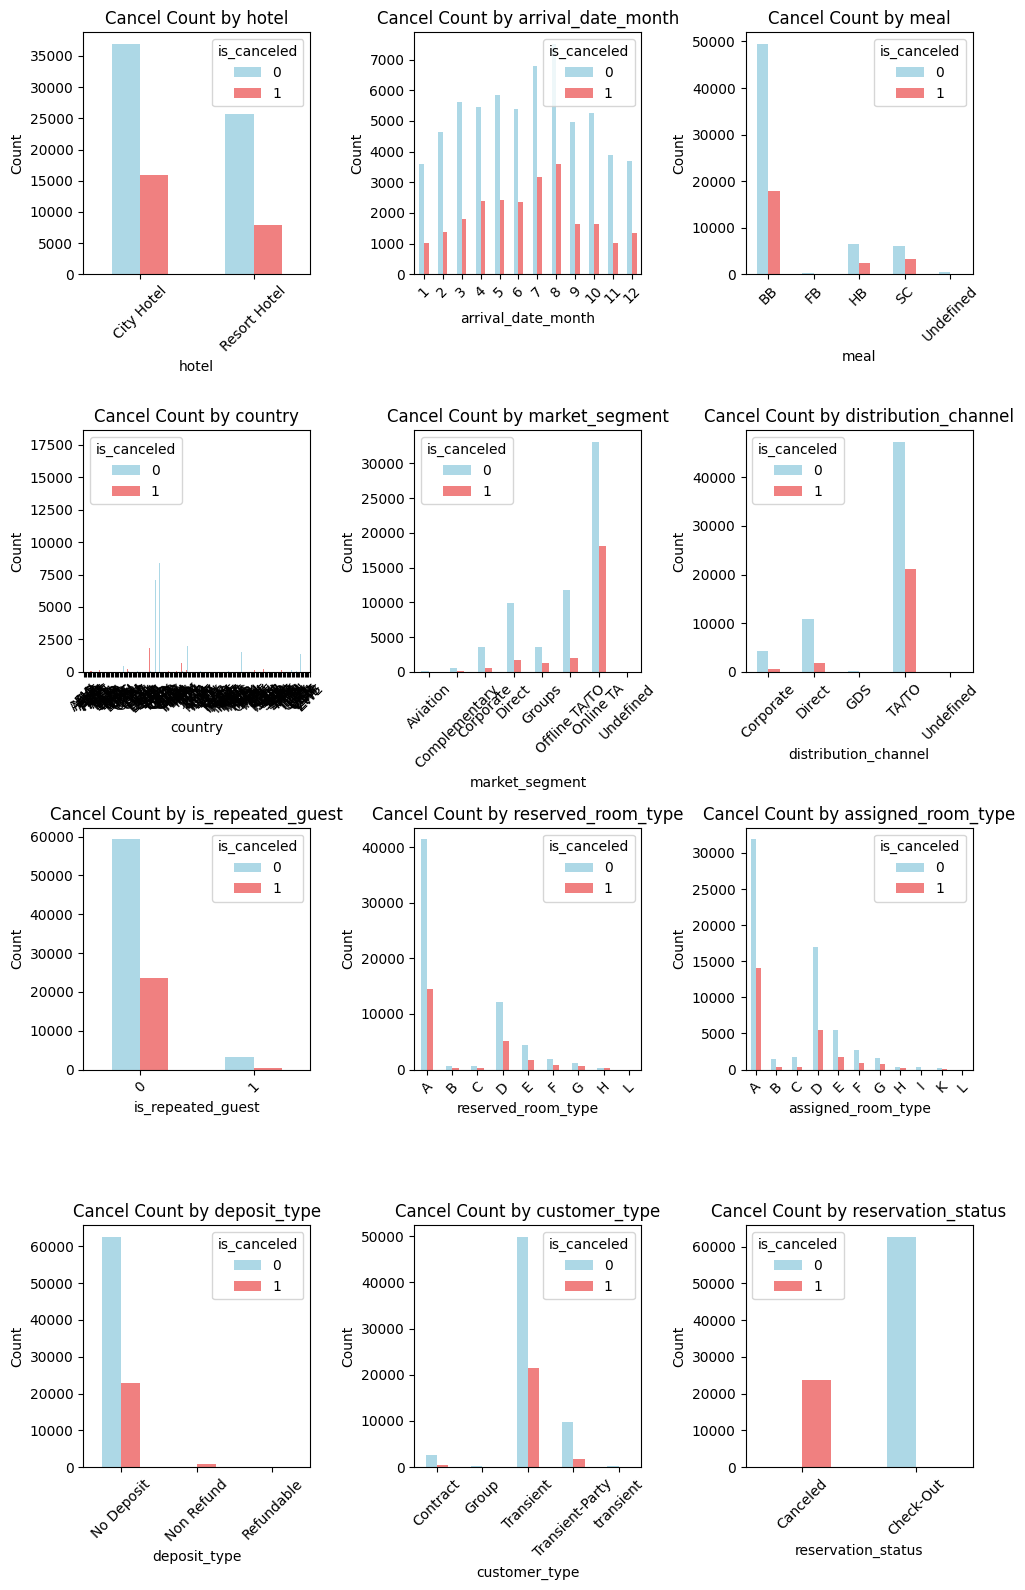

In [238]:
# Initializing an empty dictionary to store results
cancel_counts_by_category = {}

# Looping over each categorical column
for col in categorical_columns:
    # Grouping by both categorical column and is_canceled, counting the number of occurrences
    cancel_counts_by_category[col] = df.groupby([col, 'is_canceled']).size().unstack(fill_value=0)

# Number of columns for the grid layout (this can be adjusted)
cols = 3

# Calculating the number of rows dynamically based on the number of categorical columns
rows = (len(categorical_columns) + cols - 1) // cols  # Ensures no empty rows

# Creating subplots with the correct number of rows and columns
fig, axes = plt.subplots(rows, cols, figsize=(10, 4 * rows))

# Flattening the axes to make it easier to loop through
axes = axes.flatten()

# Displaying the results for each categorical column
for i, col in enumerate(cancel_counts_by_category):
    ax = axes[i]
    
    # Plotting the count of cancellations (1) vs non-cancellations (0) within each category
    data = cancel_counts_by_category[col]
    data.plot(kind='bar', stacked=False, ax=ax, color=['lightblue', 'lightcoral'])
    
    ax.set_title(f'Cancel Count by {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45)

# Removing any extra empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjusting layout 
plt.tight_layout()
plt.show()

In [240]:
# Initializing an empty dictionary to store results
cancel_counts_by_category = {}

# Looping over each categorical column
for col in categorical_columns:
    # Grouping by both categorical column and is_canceled, counting the number of occurrences
    cancel_counts_by_category[col] = df.groupby([col, 'is_canceled']).size().unstack(fill_value=0)

'''
for col in cancel_counts_by_category:
    print(f"Cancel counts for {col}:")
    print(cancel_counts_by_category[col], "\n")
'''

'\nfor col in cancel_counts_by_category:\n    print(f"Cancel counts for {col}:")\n    print(cancel_counts_by_category[col], "\n")\n'

<span style="font-size: 18px;"> **Result Interpretation**

**Hotel:**

City Hotel has a higher number of cancellations (15887) compared to Resort Hotel (7899). The non-cancellation count in City Hotel (36947) is also higher than in Resort Hotel (25749), indicating City Hotel experiences more cancellations overall.
Arrival Date Month:

Higher cancellation counts occur from July (3179) to August (3588), indicating these months might have more frequent cancellations.
January and February have relatively lower cancellations, indicating possibly fewer cancellations during these months.

**Meal:**

The "BB" meal plan has the highest non-cancellations (49483) and cancellations (17863).
Meal plans "FB" and "Undefined" show significantly fewer cancellations, possibly reflecting their rarity.
Country:

Countries like AGO (Angola) and ALB (Albania) have relatively higher cancellation counts.
Some countries (e.g., ABW – Aruba) have almost no cancellations, while others show a very small number of cancellations.

**Market Segment:**

Online TA (Travel Agencies) has the highest cancellations (18156), showing a high volume of cancellations within this segment.
"Direct" and "Offline TA/TO" segments also show significant cancellations, while "Aviation" and "Complementary" segments show fewer cancellations.

**Distribution Channel:**

TA/TO (Travel Agents / Tour Operators) has the highest cancellation counts (21215), indicating travel agencies tend to have more cancellations.
Corporate and GDS (Global Distribution Systems) show lower cancellation counts, suggesting that cancellations in these channels are less frequent.

**Is Repeated Guest:**

Repeated guests (1) show fewer cancellations (268) compared to non-repeated guests (23518). This suggests that returning guests are less likely to cancel their reservations.
Reserved Room Type:

Reserved room types "A" and "D" have the highest cancellation counts, showing that these room types might be more prone to cancellations.
Room types like "L" show very few cancellations, indicating these rooms are either rarely booked or less likely to be canceled.

**Assigned Room Type:**

Similar to reserved room types, "A" and "D" assigned room types have the highest cancellations.
"I" and "K" show very few cancellations, indicating they might be less commonly assigned or rarely canceled.
Deposit Type:

"No Deposit" has the highest cancellation count (22847), as expected, since guests who don’t pay in advance may cancel more frequently.
"Non Refund" and "Refundable" have much fewer cancellations, which indicates that guests who prepay or book refundable rooms tend to cancel less.

**Customer Type:**

"Transient" guests have the highest cancellations (21478), suggesting that one-off guests are more prone to cancel.
"Contract" guests have significantly fewer cancellations, indicating their reservations are likely more committed.

**Reservation Status:**

"Canceled" is unsurprisingly all cancellations (23786), while "Check-Out" shows no cancellations, indicating no cancellation occurred for these entries.


<span style="font-size: 18px;">**Summary:**

**Hotel type, market segment, distribution channel, and customer type significantly impact cancellation counts.
Months like July and August have higher cancellations.
Guests who don’t pay upfront or are transient have higher cancellation rates.**

<span style="font-size: 20px;">**Correlation Analysis:**

Evaluating correlation of categorical columns with is_canceled(binary) and adr(continuous) features using random forest feature importance:**

Feature importance indicates which features contribute the most to predicting the target variable, in our case, "is_canceled"/"adr". While Pearson correlation is limited to numerical features, random forests can handle both numerical and categorical features. 

In [ ]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

# Encoding categorical features
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

<span style="font-size: 18px;">**Correlation Analysis: Average Daily Rate**

In [251]:
# we use RandomForestRegressor to extract feature_importance for adr(continuous target)
X = df[categorical_columns]
y_adr = df['adr']

rf_adr = RandomForestRegressor(n_estimators=100)
rf_adr.fit(X, y_adr)

# ADR Feature Importance
feature_importance = pd.DataFrame({
    "Feature": categorical_columns,
    "Importance": importances_adr
}).sort_values(by="Importance", ascending=False)

feature_importance

,Feature,Importance
1,arrival_date_month,0.308659
7,reserved_room_type,0.236020
0,hotel,0.144631
4,market_segment,0.105631
3,country,0.065506
2,meal,0.046775
8,assigned_room_type,0.035779
5,distribution_channel,0.018778
10,customer_type,0.016817
11,reservation_status,0.012579


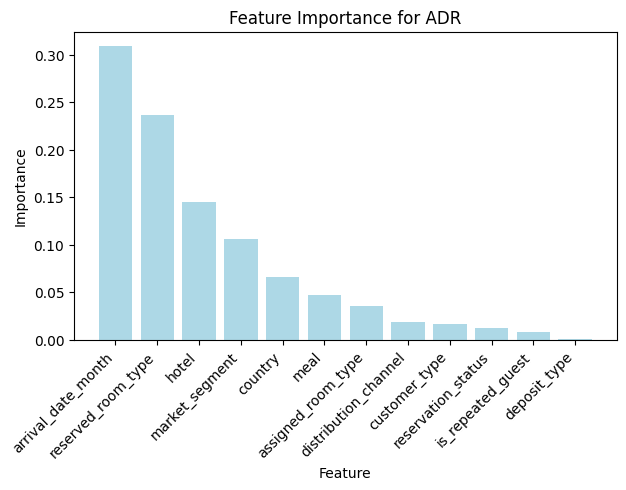

In [254]:
# Plotting feature importance (ADR)
plt.figure(figsize=(7,4))
plt.bar(feature_importance["Feature"], feature_importance["Importance"], color='lightblue')
plt.xticks(rotation=45, ha="right")  
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Importance for ADR")
plt.show()

<span style="font-size: 17px;">**Result Intepretation**

The most influential categorical feature affecting ADR is arrival_date_month (0.3087), indicating strong seasonal variations in pricing. Reserved_room_type (0.2360) and hotel type (0.1446) also play significant roles, suggesting that room category and hotel type heavily impact pricing. Market segment (0.1056) and country (0.0655) further highlight how customer origin and booking channels influence ADR. Features like meal type, assigned room type, and distribution channel have moderate effects, while customer type, reservation status, and deposit type contribute minimally. Notably, deposit_type (0.0012) and is_repeated_guest (0.0077) have negligible importance, indicating that repeat guests and deposit policies have little impact on ADR.

<span style="font-size: 18px;">**Correlation Analysis: is_canceled**

In [255]:
# Preparing the data for prediction
X = df[categorical_columns]
y_cancel = df['is_canceled']

# Fitting the model (is_canceled)
rf_cancel = RandomForestClassifier(n_estimators=100)
rf_cancel.fit(X, y_cancel)
importances_cancel = rf_cancel.feature_importances_

# Feature Importance
feature_importance = pd.DataFrame({
    "Feature": categorical_columns,
    "Importance": importances_cancel
}).sort_values(by="Importance", ascending=False)

feature_importance

,Feature,Importance
11,reservation_status,0.931199
4,market_segment,0.022879
3,country,0.011801
9,deposit_type,0.010020
5,distribution_channel,0.007044
10,customer_type,0.005553
8,assigned_room_type,0.003698
7,reserved_room_type,0.002360
1,arrival_date_month,0.001754
6,is_repeated_guest,0.001618


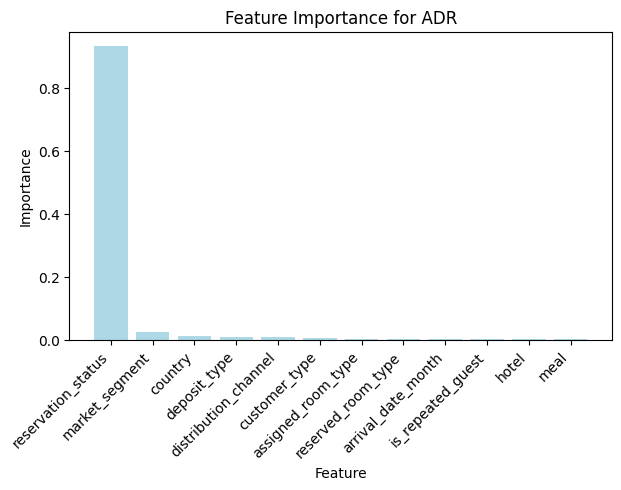

In [256]:
# Plotting feature importance (is_cancelled)
plt.figure(figsize=(7,4))
plt.bar(feature_importance["Feature"], feature_importance["Importance"], color='lightblue')
plt.xticks(rotation=45, ha="right")  
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Importance for ADR")
plt.show()

<span style="font-size: 17px;">**Important Note:**

The reservation_status directly reflects the outcome (i.e., whether a booking was canceled or not), making it a leakage feature. In reality, we do not have access to the final status of a reservation when making predictions—our goal is to predict cancellations before they happen, based on available booking details.

If we include reservation_status, the model will achieve artificially high accuracy, but it won’t generalize well to new data because it relies on information that wouldn't be available in a real-world scenario. By removing it, we ensure that the model learns patterns from actual predictive features, such as booking source (market_segment), country, deposit_type, and other factors that influence cancellations.

Thus, we should recalculate feature importance after excluding reservation_status to get a more realistic understanding of what truly drives cancellations.


<span style="font-size: 18px;">**Recalculation of Feature Importance:**

In [263]:
# Removing reservation_status from list of columns
categorical_columns_no_reservation = [col for col in categorical_columns if col != 'reservation_status']

# Preparing the data for prediction
X = df[categorical_columns_no_reservation]
y_cancel = df['is_canceled']

# Fitting the model (is_canceled)
rf_cancel = RandomForestClassifier(n_estimators=100)
rf_cancel.fit(X, y_cancel)
importances_cancel = rf_cancel.feature_importances_

# Feature Importance
feature_importance = pd.DataFrame({
    "Feature": categorical_columns_no_reservation,
    "Importance": importances_cancel
}).sort_values(by="Importance", ascending=False)

feature_importance

,Feature,Importance
3,country,0.323445
1,arrival_date_month,0.168430
4,market_segment,0.132832
8,assigned_room_type,0.089213
7,reserved_room_type,0.066326
10,customer_type,0.056736
9,deposit_type,0.053781
5,distribution_channel,0.035679
2,meal,0.033133
0,hotel,0.024386


In [ ]:
# Plotting feature importance (is_canceled)
plt.figure(figsize=(7,4))
plt.bar(feature_importance["Feature"], feature_importance["Importance"], color='lightblue')
plt.xticks(rotation=45, ha="right")  
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Importance for ADR")
plt.show()

<span style="font-size: 18px;">**Result Intepretation**

The most influential factor in predicting cancellations is the country of the guest, suggesting that regional booking behaviors or policies significantly impact cancellation rates. Arrival month also plays a major role, likely due to seasonal demand fluctuations. Market segment and room assignment type further indicate that how a booking is made and the type of room allocated influence cancellations, possibly due to pricing or availability issues. Customer type and deposit type contribute notably, highlighting that different booking policies and payment commitments affect cancellation likelihood. Distribution channel and meal type have moderate impact, suggesting the booking source and included amenities might influence customer commitment. Hotel type, repeat guest status, and reserved room type have the least impact, indicating that loyalty or room preferences play a smaller role in cancellations.

### Time Series Analysis of Average Daily Rate

<span style="font-size: 20px;">**Question**: How does the average daily rate (ADR) fluctuate over time, and what seasonal trends or anomalies can be observed?

In [67]:
#!pip install statsmodels

In [ ]:
df = df_processed.copy()

In [98]:
# Combining the year, month, and day to create a full arrival date
df['arrival_date'] = pd.to_datetime(df['arrival_date_year'].astype(str) + '-' + 
                                     df['arrival_date_month'].astype(str) + '-' + 
                                     df['arrival_date_day_of_month'].astype(str))

df = df.sort_values('arrival_date')

In [101]:
# Plotting ADR over time to observe any trends or anomalies
'''
plt.figure(figsize=(14, 7))
plt.plot(df['arrival_date'], df['adr'], color='b', label='ADR')
plt.title('Average Daily Rate (ADR) Over Time')
plt.xlabel('Date')
plt.ylabel('ADR')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()
'''

"\nplt.figure(figsize=(14, 7))\nplt.plot(df['arrival_date'], df['adr'], color='b', label='ADR')\nplt.title('Average Daily Rate (ADR) Over Time')\nplt.xlabel('Date')\nplt.ylabel('ADR')\nplt.legend(loc='upper left')\nplt.grid(True)\nplt.show()\n"

**NOTE**: The ADR over time plot is extremely noisy. To smooth it out, we can use a rolling average with a 30-day window.

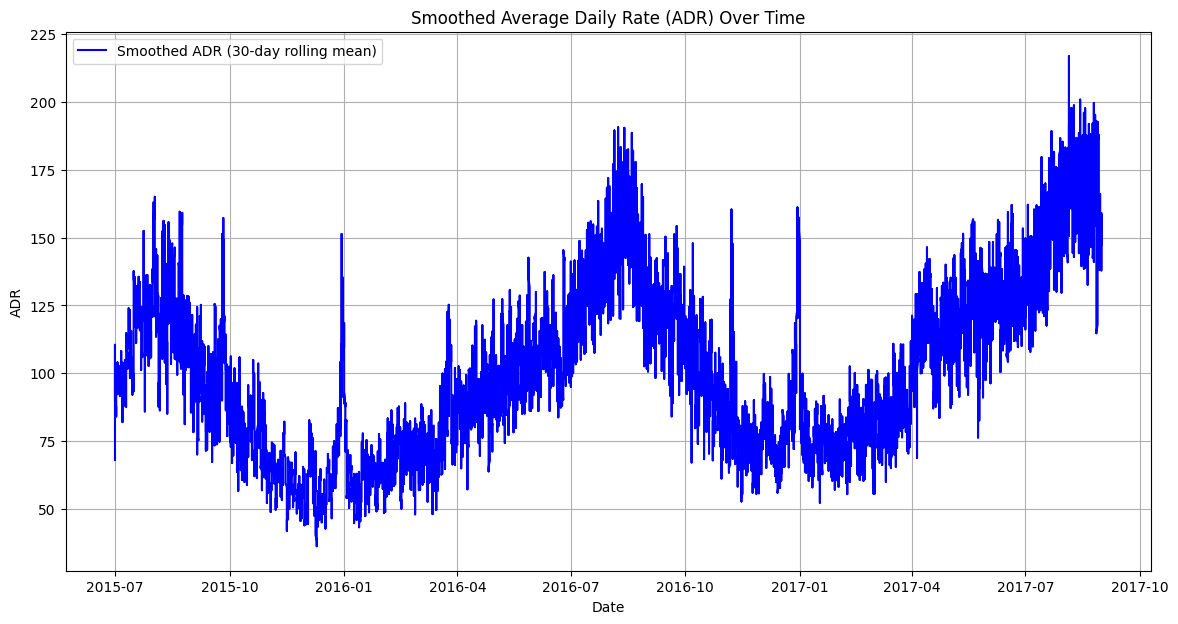

In [99]:
# Applying a rolling window of 30 days to smooth fluctuations
# arrival_date
df['adr_smooth'] = df['adr'].rolling(window=30, min_periods=1).mean()

# arrival_date
plt.figure(figsize=(14, 7))
plt.plot(df['arrival_date'], df['adr_smooth'], color='b', label='Smoothed ADR (30-day rolling mean)')
plt.title('Smoothed Average Daily Rate (ADR) Over Time')
plt.xlabel('Date')
plt.ylabel('ADR')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

<span style="font-size: 18px;">**Interpretation of 'Smoothed Average Daily Rate over Time' Plot**

The graph shows some fluctuations in ADR, possibly driven by seasonal or external factors. 

**1. Seasonal Trends and Demand Fluctuations:**
   
The minimums observed around January each year and the maximums around August likely represent typical seasonal fluctuations, with demand decreasing during the low periods. Hotels may reduce their prices during off-peak months, such as post-holiday seasons or before major events, causing a drop in ADR.

Sharp Peaks: The sharp peaks (around 2015-10, 2016-01, 2016-11, and 2017-01) suggest there may be seasonal surges or external events that temporarily raised ADR. These could be driven by a combination of high demand, pricing strategies, or market events.

**2. Interpreting Sharp Peaks (Anomalies):**

- Anomalies around January could be attributed to the combination of high seasonal demand and holiday events, leading hotels to raise prices due to limited availability during the holiday season.

- The peaks observed in October and November may be driven by early holiday bookings or local events, such as Black Friday sales, tourism festivals, or other regional factors, which could have contributed to a surge in demand.

**3. External Factors:**

The peaks could also reflect changes in the economic environment, competitor pricing, or even policy changes that impacted demand and pricing strategies. For example, a change in local regulations, like tax increases or new tourism policies, could drive fluctuations in pricing. 

**4. Dynamic Pricing and Revenue Management:**

If the hotel uses dynamic pricing, it’s likely that the peaks represent adjustments to the ADR based on fluctuating demand. These spikes could indicate adjustments to room rates in response to anticipated high demand, even if that demand isn’t fully captured by a rolling mean. Additionally, market segmentation could influence these peaks. For example, corporate bookings may command higher rates during certain periods, causing temporary increases in ADR.

**Next Steps:**

To gain a better understanding of the anomalies in ADR, it’s important to explore potential factors that could have contributed to these fluctuations. Reviewing local event calendars for the relevant period can help identify if any major conferences, festivals, or holidays coincide with the peaks. Additionally, comparing the ADR during these times with data from other hotels in the region can provide insight into whether these spikes were part of broader market trends or specific to the hotel in question. Analyzing ADR by different segments such as room type, market segment, or booking channel can also reveal whether certain types of bookings, like corporate or leisure, or specific channels, such as online travel agents or direct bookings, had a more significant impact on the ADR during these periods.

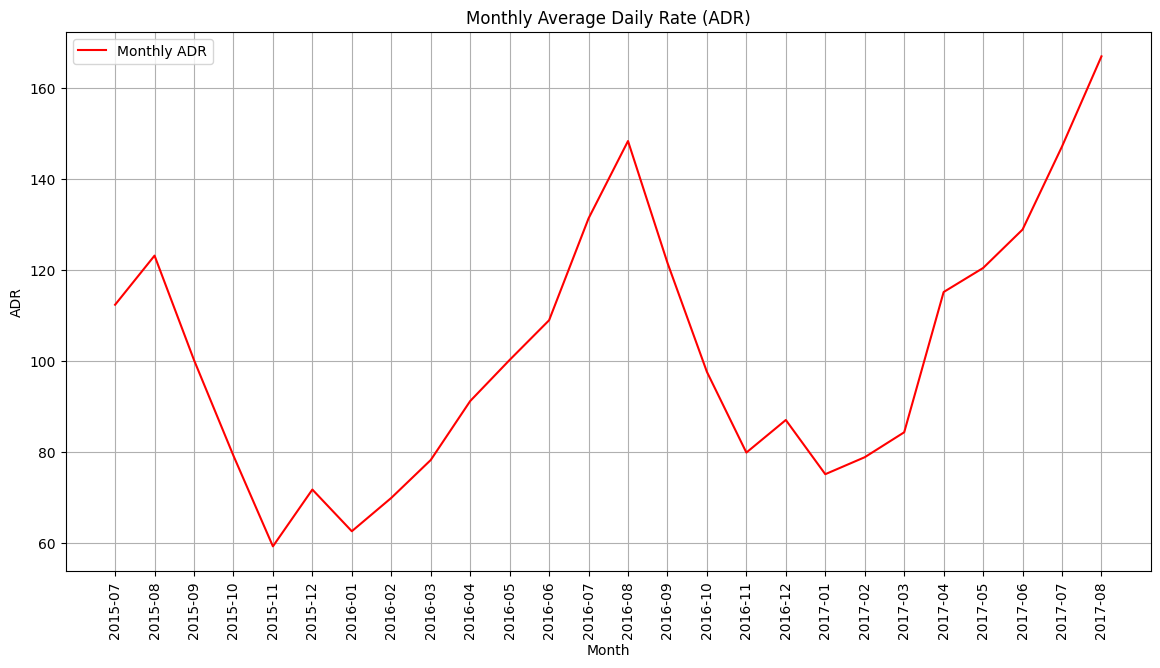

In [111]:
# Extracting month from the 'arrival_date' column (month-year basis, equal to continuous date in Tableau)
# arrival_date
df['month'] = df['arrival_date'].dt.to_period('M')
df_monthly_continuous = df.groupby('month')['adr'].mean()

plt.figure(figsize=(14, 7))
plt.plot(df_monthly_continuous.index.astype(str), df_monthly_continuous, color='r', label='Monthly ADR')
plt.title('Monthly Average Daily Rate (ADR)')
plt.xlabel('Month')
plt.ylabel('ADR')
plt.xticks(rotation=90) 
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

<span style="font-size: 18px;">**Interpretation of Monthly Average Daily Rate over Time Plot**

The Monthly Average Daily Rate (ADR) exhibits both a clear upward trend and notable seasonality. Over time, the general trajectory of the ADR has been increasing, indicating that prices are gradually rising. This upward trend suggests growing demand or higher pricing strategies in the hospitality industry. When we examine the seasonal patterns, it is evident that there are recurring fluctuations year after year. Specifically, the lowest values for ADR tend to occur in the months of November and January, likely due to decreased travel demand following the holiday season and the quieter early months of the year. 

In contrast, the peak ADR values are consistently observed in August, which aligns with the summer months when tourism typically reaches its height, driving up demand and, consequently, the average daily rate. These patterns of seasonality suggest that both external factors, such as holidays and vacation seasons, and internal factors, such as pricing strategies, play a significant role in shaping the ADR throughout the year.

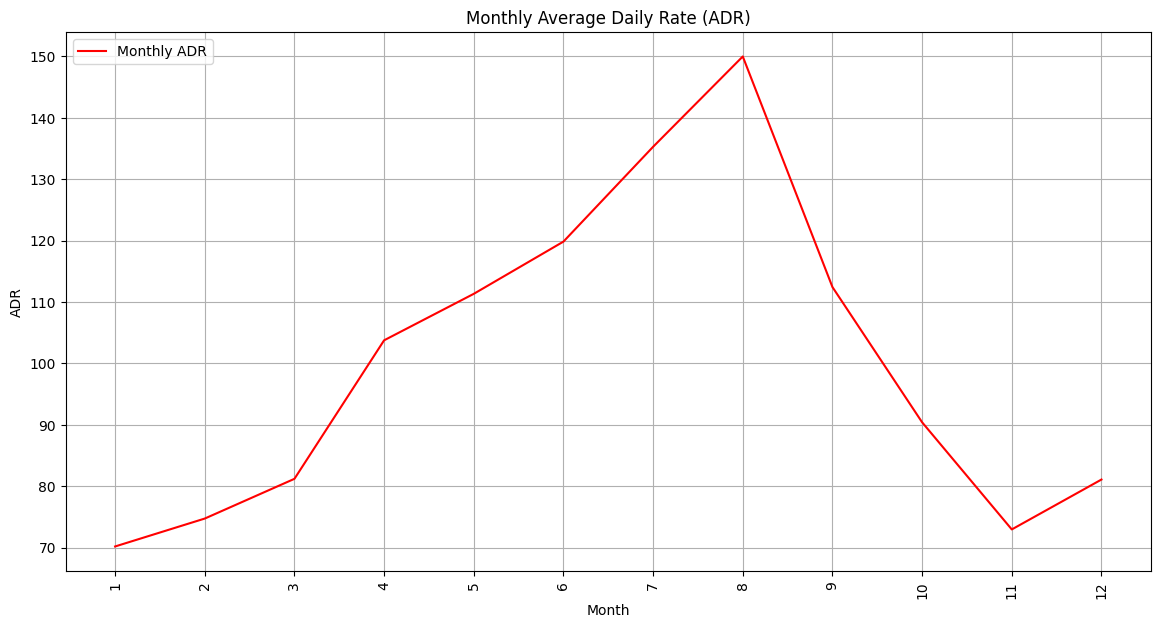

In [112]:
#Extract month from the 'arrival_date' column (monthly basis, equal to discrete date in Tableau)
df['month'] = df['arrival_date'].dt.month
df_monthly_discrete = df.groupby('month')['adr'].mean()

plt.figure(figsize=(14, 7))
plt.plot(df_monthly_discrete.index.astype(str), df_monthly_discrete, color='r', label='Monthly ADR')
plt.title('Monthly Average Daily Rate (ADR)')
plt.xlabel('Month')
plt.ylabel('ADR')
plt.xticks(rotation=90) 
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

<span style="font-size: 18px;">**ADF Test to Check for Stationarity**

Although the trend and seasonality in ADR over time are clearly evident visually, we can statistically verify stationarity using the Augmented Dickey-Fuller (ADF) test. If the p-value is below 0.05, the series is considered stationary, meaning its statistical properties, such as mean and variance, remain constant over time.

In [117]:
from statsmodels.tsa.stattools import adfuller

# Performing the Augmented Dickey-Fuller test to check stationarity (adfuller cannot handle Nan values)
result_adr = adfuller(df_monthly_continuous)  

print(f"ADF Statistic: {result_adr[0]}")
print(f"p-value: {result_adr[1]}")
print(f"Critical Values: {result_adr[4]}")

ADF Statistic: -0.44423993606428697
p-value: 0.9024461474038753
Critical Values: {'1%': -3.9240193847656246, '5%': -3.0684982031250003, '10%': -2.67389265625}


**Note**

Using df_monthly_continuous in adfuller test, as opposed to df_monthly_discrete, will preserve the time series structure on a year-month basis, which is more appropriate for time series analysis and can better account for both long-term trends and seasonality. It will give us more meaningful results from ADF because we're not discarding the year-to-year variation.

**Interpretation of 'adfuller' Test:**

The ADF statistic is a negative value, but it is much higher than the critical values for all significance levels (1%, 5%, and 10%). This suggests that the test statistic is not far enough from 0 to reject the null hypothesis.

The p-value is very high (greater than the typical significance threshold of 0.05), which means that there is insufficient evidence to reject the null hypothesis of the test. In other words, the series is likely non-stationary.

To make it stationary, we can apply differencing, log transformation, or other techniques before using models like ARIMA (for time series forecasting.

For further analysis, we can plot the **Auto-Correlation Function (ACF)** and **Partial Auto-Correlation Function (PACF)** to help identify seasonality and lag relationships in the ADR data.

<span style="font-size: 19px;">**Month-over-Month (MoM) ADR - Year-over-Year (YoY) ADR**

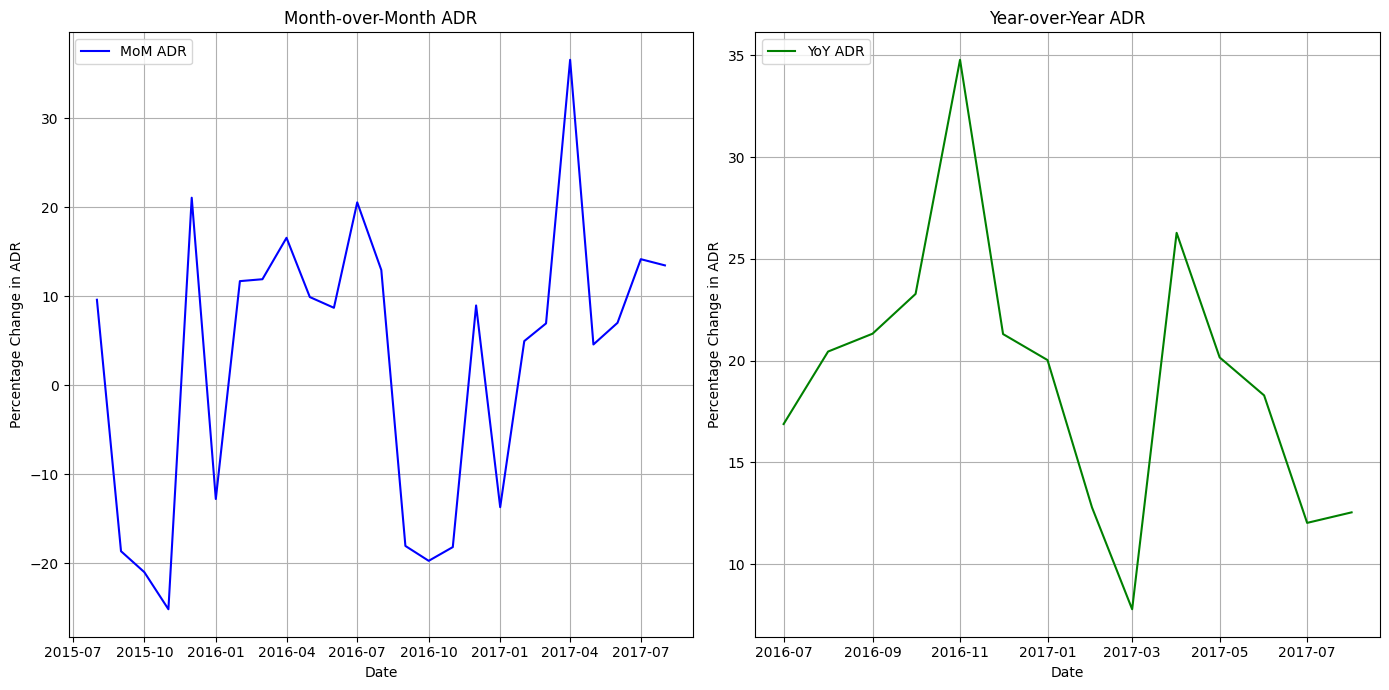

In [120]:
# Extracting year and month from 'arrival_date' (redoing month & year extraction for the sake of this question)
df['year'] = df['arrival_date'].dt.year
df['month'] = df['arrival_date'].dt.month

# 'Group by' 'year' and 'month' to calculate monthly average ADR
df_monthly = df.groupby(['year', 'month'])['adr'].mean().reset_index()

# Creating a 'Date' column for better plotting
df_monthly['Date'] = pd.to_datetime(df_monthly[['year', 'month']].assign(day=1))

# Sorting by date to ensure the data is in the correct order
df_monthly = df_monthly.sort_values('Date')

# Calculating MoM ADR (Percentage change from one month to the next)
df_monthly['MoM_ADR'] = df_monthly['adr'].pct_change() * 100

# Calculating YoY ADR (Percentage change from the same month in the previous year)
df_monthly['YoY_ADR'] = df_monthly['adr'].pct_change(periods=12) * 100  # Shift by 12 months


# Plotting

plt.figure(figsize=(14, 7))

# Subplot 1: Month-over-Month ADR
plt.subplot(121)
plt.plot(df_monthly['Date'], df_monthly['MoM_ADR'], color='blue', label='MoM ADR')
plt.title('Month-over-Month ADR')
plt.xlabel('Date')
plt.ylabel('Percentage Change in ADR')
plt.grid(True)
plt.legend(loc='upper left')

# Subplot 2: Year-over-Year ADR
plt.subplot(122)
plt.plot(df_monthly['Date'], df_monthly['YoY_ADR'], color='green', label='YoY ADR')
plt.title('Year-over-Year ADR')
plt.xlabel('Date')
plt.ylabel('Percentage Change in ADR')
plt.grid(True)
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

<span style="font-size: 20px;">**How To Read These Plots**

The point for 2016-10 (October 2016) represents the ADR for that specific month. Here's how it appears in each graph:

- **For the Month-over-Month (MoM) ADR graph:**
                                                       
The point at 2016-10 represents the percentage change in ADR between October 2016 and September 2016. Specifically, it shows how the ADR in October 2016 compares to the ADR in September 2016. If it's positive, the ADR increased from September to October; if negative, the ADR decreased.

- **For the Year-over-Year (YoY) ADR graph:**
The point at 2016-10 represents the percentage change in ADR between October 2016 and October 2015. This means we compare the ADR for October 2016 to the ADR for the same month (October) in the previous year (October 2015). If it's positive, it indicates that the ADR increased in October 2016 compared to October 2015; if negative, it indicates a decrease.

<span style="font-size: 16px;">**Summary of MoM & YoY**

MoM ADR: The point represents the change from the previous month (September 2016 to October 2016).

YoY ADR: The point represents the change from the same month in the previous year (October 2015 to October 2016).


<span style="font-size: 20px;">**Interpretation of YoY ADR:**

- 2016-07 to 2016-11 (Initial Increase):

The graph starts at 2016-07, and ADR begins to increase, peaking at 2016-11. The increase in ADR relative to the same months in the previous year indicates that prices in 2016 were higher compared to 2015. While both years might experience the same seasonal fluctuations (summer, holidays, etc.), the rise suggests that, in 2016, the ADR for these months increased more significantly than in 2015. This could be due to factors such as inflation or increased pricing strategies in 2016, even though both years likely experienced similar levels of demand.

- 2016-11 to 2017-03 (Decline and Minimum):

After reaching a peak in 2016-11, ADR starts to decline and reaches its minimum around 2017-03. This decrease shows that ADR in 2017 for those months (Nov-Mar) was relatively lower than in 2016. It could indicate that prices dropped in 2017 during the off-peak season compared to 2016, potentially due to lower demand, price adjustments, or market saturation.

- 2017-03 to 2017-04 (Second Increase):

Starting from 2017-03, ADR experiences a sharp increase that peaks in 2017-04. Unlike the gradual rise leading to the peak in 2016-11, this increase occurred more suddenly within just one month, suggesting a quick upward adjustment in pricing or a spike in demand in early 2017. However, the second peak is still lower than the first one, indicating that the overall growth in ADR in 2017 was less significant than the previous year. This could imply that while there was an increase in demand or pricing in early 2017, it was not as pronounced or sustained as in the previous year, reflecting less aggressive pricing strategies or moderate demand growth compared to 2016.

- 2017-05 to 2017-08 (Decline):

After the second peak, ADR starts to decrease again, showing that the increase in 2017 ADR compared to 2016 was not sustained. This decline may indicate a return to seasonal trends, but with lower increases relative to 2016, possibly due to weaker demand or less aggressive pricing strategies.

<span style="font-size: 20px;">**QUESTION:** What is the trend of cancellation rates over time, and are there specific months or seasons with significantly higher cancellation rates?


In [ ]:
df = df_processed.copy()

In [290]:
# Extracting the year-month from the reservation_status_date
df['month'] = df['reservation_status_date'].dt.to_period('M')

# Grouping by month and is_canceled to count cancellations and non-cancellations
cancellation_counts = df.groupby(['month', 'is_canceled']).size().unstack(fill_value=0)
total_count = cancellation_counts[0] + cancellation_counts[1]

# Extracting the counts for canceled and non-canceled reservations
cancelled_counts = cancellation_counts[1] 
non_cancelled_counts = cancellation_counts[0]  

# Creating a DataFrame to store these values
cancel_non_cancel_df = pd.DataFrame({
    'Month': cancellation_counts.index.astype(str),
    'Canceled Reservations': cancelled_counts,
    'Non-Canceled Reservations': non_cancelled_counts,
    'Total Number of Reservations': total_count,
    'Cancellation Rate': cancelled_counts/total_count* 100
})

# Display the DataFrame

In [292]:
cancel_non_cancel_df[:3]

,Month,Canceled Reservations,Non-Canceled Reservations,Total Number of Reservations,Cancellation Rate
month,,,,,
2015-07,2015-07,445,968,1413,31.493277
2015-08,2015-08,401,1829,2230,17.982063
2015-09,2015-09,434,2243,2677,16.212178


In [291]:
# Restricting the date to the period we have a reasonable amount of data to conduct this analysis properly
cancel_non_cancel_df = cancel_non_cancel_df[(cancel_non_cancel_df['Month'] >= '2015-07') & (cancel_non_cancel_df['Month'] < '2017-09')]

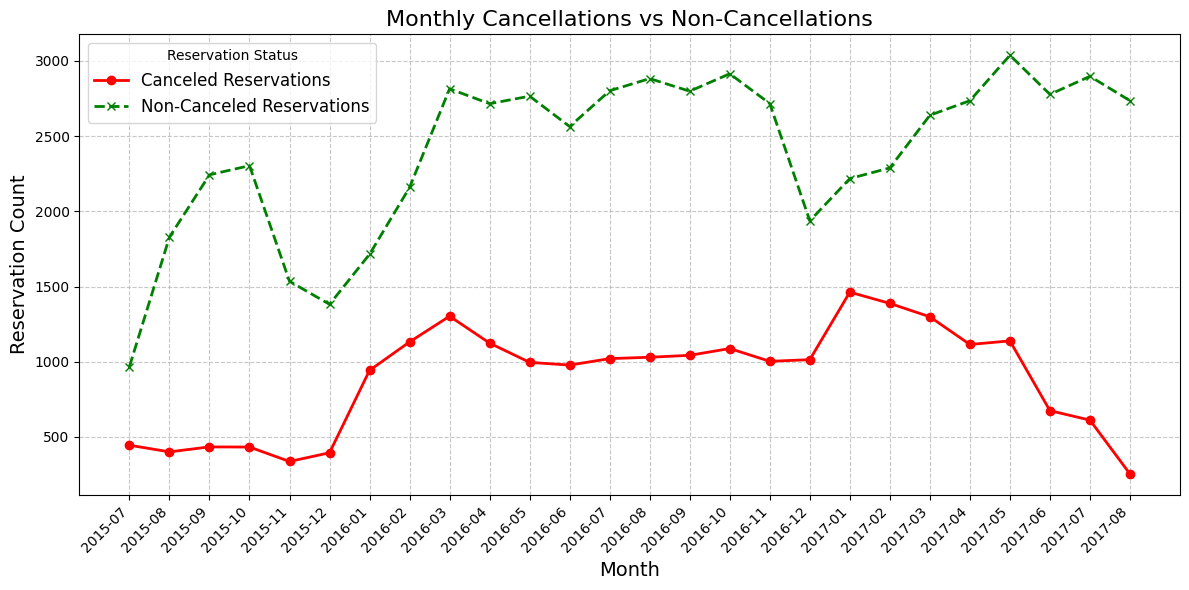

In [246]:
# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(cancel_non_cancel_df['Month'], cancel_non_cancel_df['Canceled Reservations'], label='Canceled Reservations', color='red', marker='o', linestyle='-', linewidth=2)
plt.plot(cancel_non_cancel_df['Month'], cancel_non_cancel_df['Non-Canceled Reservations'], label='Non-Canceled Reservations', color='green', marker='x', linestyle='--', linewidth=2)

# Adding labels and title
plt.title('Monthly Cancellations vs Non-Cancellations', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Reservation Count', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title="Reservation Status", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Showing the plot
plt.tight_layout()
plt.show()

<span style="font-size: 18px;">**Key Observations:**

**Overall Trends:**

There is a significant variation in the number of canceled reservations month by month.

The number of canceled reservations tends to increase during the first few months of each year (e.g., January and February 2016), peaking at 1463 cancellations in January 2017.
Summer months, such as July and August, tend to have fewer cancellations, with August 2017 showing the lowest cancellation number at 254. This suggests that cancellations may be lower during the vacation season.

**Cancellation Rate:**

In general, cancellations are higher during the winter months, particularly in January and February, likely due to weather-related issues or changes in travel plans after the holiday season.
The percentage of canceled reservations relative to non-canceled reservations can be calculated and analyzed for trends.
Reservation Consistency:

The non-canceled reservations show a more stable and steady trend, with gradual increases during most months, likely indicating an increase in demand or booking capacity.
There is a peak in non-canceled reservations around May 2017, reaching 3038, which could indicate increased travel or promotions during the spring.
Business Insights:

High cancellation rates in certain months might indicate areas for improvement, such as better prediction or management of cancellations (e.g., providing better cancellation policies or engaging customers who are more likely to cancel).
The months with higher cancellations (e.g., January, February, and early months of the year) may also be an area to target for promotional or discount offers to encourage customers to maintain their reservations.
Seasonal Effects:

It's noticeable that the number of cancellations tends to decrease during summer months, particularly in June, July, and August. This suggests that people are more likely to follow through with their reservations during peak travel seasons.

In [298]:
#cancel_non_cancel_df["Canceled Percentage of Total"]

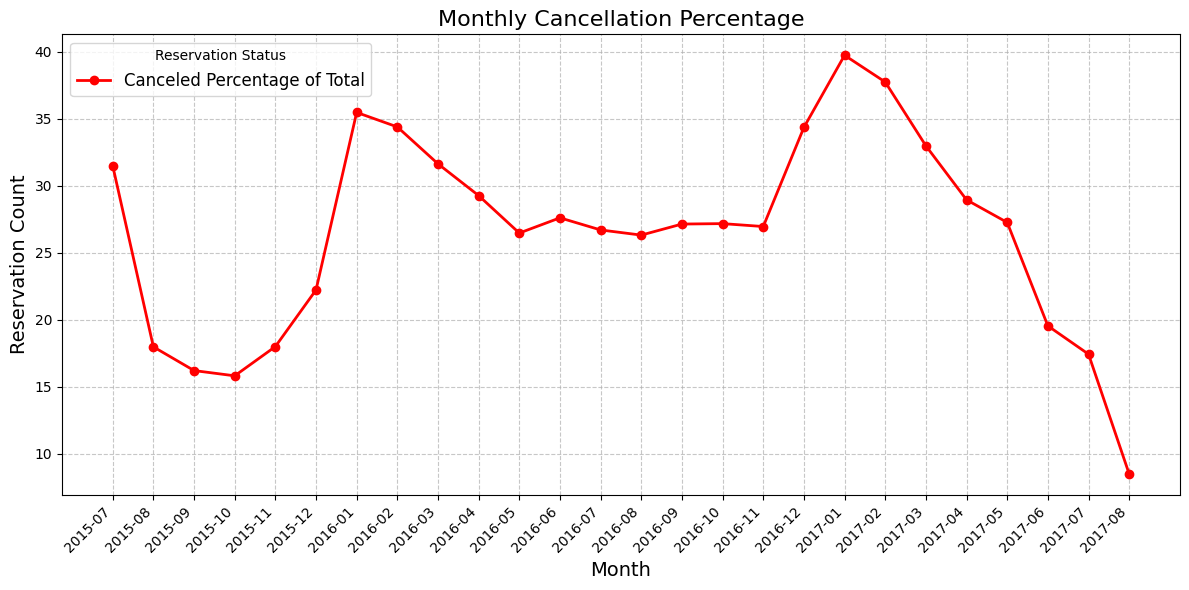

In [285]:
# Plotting the 'percentage of cancelled' results
plt.figure(figsize=(12, 6))
plt.plot(cancel_non_cancel_df['Month'], cancel_non_cancel_df['Cancellation Rate'], label='Cancellation Rate', color='red', marker='o', linestyle='-', linewidth=2)

# Adding labels and title
plt.title('Monthly Cancellation Percentage', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Reservation Count', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title="Reservation Status", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Showing the plot
plt.tight_layout()
plt.show()

<span style="font-size: 19px;">**Interpretation of the Plot**

The Canceled Percentage of Total fluctuates over time, with notable trends:

2015: The cancellation rate starts high in July (31.49%) but drops significantly by October (~15.82%), indicating stable bookings towards the end of the year.

Early 2016: The rate rises sharply in January (35.48%) and February (34.40%), likely due to post-holiday cancellations or unfavorable weather affecting travel plans.

Mid-2016: The cancellation rate stabilizes around 26-27%, suggesting relatively predictable booking behavior.

Late 2016 - Early 2017: A peak occurs in January 2017 (39.74%), possibly due to a mix of overbooking and seasonal demand changes.

Mid-2017: A sharp decline follows, reaching only 8.49% in August 2017, likely due to better booking policies, increased demand, or fewer speculative reservations.

Overall, cancellations seem influenced by seasonality, overbooking, and changes in travel behavior. The drop in late 2017 suggests improvements in reservation policies or external factors stabilizing demand.

Mean Cancellation Percentage: 26.44%
Median Cancellation Percentage: 27.16%
Standard Deviation of Cancellation Percentage: 7.63


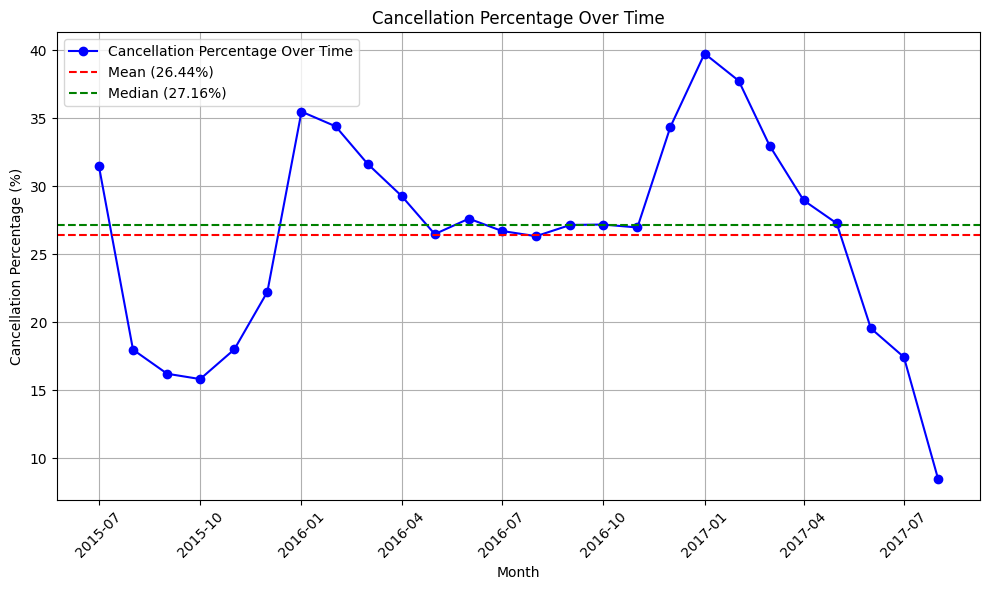

In [297]:
# Ensuring index is in datetime format (if not already)
if not isinstance(cancel_non_cancel_df.index, pd.DatetimeIndex):
    cancel_non_cancel_df.index = pd.to_datetime(cancel_non_cancel_df.index)

# Calculating statistics
mean_canceled_percentage = cancel_non_cancel_df['Cancellation Rate'].mean()
median_canceled_percentage = cancel_non_cancel_df['Cancellation Rate'].median()
std_canceled_percentage = cancel_non_cancel_df['Cancellation Rate'].std()

# printing Output of the results
print(f"Mean Cancellation Percentage: {mean_canceled_percentage:.2f}%")
print(f"Median Cancellation Percentage: {median_canceled_percentage:.2f}%")
print(f"Standard Deviation of Cancellation Percentage: {std_canceled_percentage:.2f}")

# Plotting the cancellation rate over time
plt.figure(figsize=(10, 6))
plt.plot(cancel_non_cancel_df.index, cancel_non_cancel_df['Cancellation Rate'], marker='o', color='b', label='Cancellation Percentage Over Time')

# Plotting mean and median as horizontal lines
plt.axhline(y=mean_canceled_percentage, color='r', linestyle='--', label=f'Mean ({mean_canceled_percentage:.2f}%)')
plt.axhline(y=median_canceled_percentage, color='g', linestyle='--', label=f'Median ({median_canceled_percentage:.2f}%)')

# Formatting
plt.title('Cancellation Percentage Over Time')
plt.xlabel('Month')
plt.ylabel('Cancellation Percentage (%)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()


plt.show()

<span style="font-size: 19px;">**Interpretation of Cancellation Percentage Trends Plot**

The fluctuations in the Cancellation Rate over time reveal key patterns and potential influencing factors:

1. Early U-Shaped Decline and Rise (2015-07 to 2016-01)
   
The initial drop from 32% to a low of 16% (Oct 2015) suggests a period of stability, possibly due to seasonality (e.g., fewer cancellations during a peak booking period).
The rise to 36% (Jan 2016) indicates a sudden increase in cancellations. This could be due to post-holiday cancellations, adverse weather conditions, or economic factors affecting customers' ability to travel.

2. Stabilization Around the Mean (Mid-2016 to Late 2016)
   
From May 2016 to Nov 2016, cancellation rates hovered around the mean (26.44%) with minimal fluctuations.
This suggests that after an initial period of volatility, cancellations align with an expected long-term trend.

3. Sharp Increase and Peak (Late 2016 to Early 2017)

A strong upward trend starts in Nov 2016, peaking at 40% in Jan 2017.
Possible reasons: A policy change (e.g., stricter cancellation policies could lead to last-minute cancellations).
External factors like economic downturns, weather conditions, or booking patterns.
Increased speculative bookings (customers booking multiple options and canceling later).

4. Continuous Decline Below the Mean (Mid-2017 Onward)

After Jan 2017, cancellation rates steadily decrease, crossing the mean around May 2017 and falling well below it for the remaining period.
This could indicate:
Better booking policies (e.g., stricter refund rules discouraging cancellations).
Shifts in customer behavior (e.g., more confident bookings with fewer speculative reservations).
Improvements in customer communication (e.g., better reminders, incentives to retain bookings).

<span style="font-size: 18px;">**Key Insights & Recommended Actions**

**Investigate peak periods (Jan 2016 & Jan 2017):**

- Were these caused by external factors (e.g., seasonality, economic issues) or internal policies?
- If due to policy changes, evaluate whether they had unintended consequences.

**Monitor cancellation trends during peak travel periods (Dec-Jan):**

- Consider offering incentives (discounts, flexible rebooking) to reduce cancellations.
- Implement better forecasting models to prepare for high cancellation periods.

**Assess the impact of stricter policies post-2017:**

- The continuous decline suggests something actively reduced cancellations, was it policy-related?
If so, maintain policies that successfully reduce unnecessary cancellations while balancing customer satisfaction.

**Enhance customer retention strategies:**

- Offer reminders, loyalty programs, or flexible booking options to encourage commitment.
- Identify cancellation reasons (e.g., price sensitivity, trip uncertainty) and tailor solutions.

<span style="font-size: 18px;">**Final Takeaway**

The Cancellation Rate trends suggest a strong seasonal influence, policy-driven impacts, and customer behavior shifts. By analyzing these trends further, the company can optimize policies and customer engagement strategies to reduce unnecessary cancellations while maintaining flexibility for genuine customer needs.

# Average Daily Rate (ADR) Forecasting

## Overview

Average Daily Rate (ADR) forecasting is the process of predicting the expected revenue per occupied room in the hospitality industry. It helps hotels optimize pricing strategies, maximize revenue, and improve financial planning.

**Key Factors Influencing ADR Forecasting:**

- Seasonality: Demand fluctuations based on holidays, weather, and peak travel periods.
- Market Trends: Economic conditions, competitor pricing, and industry shifts.
- Booking Patterns: Lead time, cancellation rates, and guest segments.
- Special Events & Promotions: Conferences, festivals, and hotel-specific discounts.

**Forecasting Methods:**

- Historical Data Analysis: Using past ADR trends to predict future values.
- Time Series Models: ARIMA, Exponential Smoothing, and Seasonal Decomposition.
- Machine Learning Approaches: Regression models, decision trees, and deep learning for dynamic pricing.

**Importance of ADR Forecasting:**

- Enhances revenue management by setting competitive room rates.
- Helps in budgeting and financial planning for hotel operations.
- Supports dynamic pricing strategies to maximize occupancy and profitability.
- Accurate ADR forecasting enables hotels to balance pricing, demand, and customer satisfaction, ensuring sustained revenue growth.

## Model Selection

<span style="font-size: 18px;">**Top Choices**

**Gradient Boosting Machines (GBM) – (XGBoost, LightGBM, CatBoost):**

- Pros: Handles missing data, categorical features, and non-linear relationships well.
- Cons: Can be slow on large datasets, requires tuning.
- Why? GBM models generally perform well in structured tabular data.

**Random Forest Regressor:**

- Pros: Handles non-linearity well, robust to outliers, and interpretable with feature importance.
- Cons: Can be slow with many trees, less effective on small datasets.
- Why? It's a strong, easy-to-use model that can capture complex interactions in the features.

**Neural Networks (Deep Learning):**

- Pros: Can model highly complex relationships, captures non-linear patterns, and can learn feature representations automatically.
- Cons: Requires a large dataset to generalize well, prone to overfitting, computationally expensive, and harder to interpret.
- Why? If the dataset were larger, neural networks could uncover deep patterns, but for structured tabular data, they often underperform compared to tree-based models.

**NOTE:** Given the dataset size, training a Neural Network would require regularization techniques such as dropout and batch normalization. Additionally, the model should remain relatively shallow rather than a deep network with multiple hidden layers.

## Ensemble Model: CatBoost Regressor

CatBoost is a gradient boosting algorithm optimized for categorical data, making it well-suited for hotel booking predictions where categorical features like market segment and room type play a crucial role. Its ability to handle high-cardinality features efficiently helps capture complex relationships, improving ADR forecasting accuracy.

### Initial Feature Selection

When predicting ADR, it is crucial to avoid using information that is determined after the booking process, as it can introduce data leakage. The following columns are highly correlated with reservation outcomes and should be excluded to maintain model integrity.

-<span style="font-size: 16px;">**reservation_status Feature**
    
- Post-Outcome Information:
The reservation_status column includes labels such as "Canceled," "No-Show," and "Check-Out," which are only determined after the reservation process is complete. These statuses reflect the final state of the reservation, making them unavailable at the time of booking when predicting ADR. Including this column would introduce data leakage as the model could mistakenly use information from the future to make predictions, leading to unrealistic outcomes.

- Strong Correlation with ADR:
ADR is often influenced by whether a reservation was completed or canceled, meaning that reservation_status is highly correlated with ADR. If included, the model could rely on this column to predict cancellations, which would distort the relationship between ADR and the actual predictive features. This reduces the model's generalizability, as it would learn patterns more focused on the outcome of the booking (e.g., cancellation) rather than actual pricing trends.

-<span style="font-size: 16px;">**is_canceled Feature**

Similar to reservation_status, the is_canceled column provides information about whether the reservation was canceled, which is determined after the booking. Including this feature would introduce data leakage because the model would have access to post-booking information when predicting ADR. This would result in an unfair advantage for the model, as it would indirectly know the final state of the booking at the time of prediction, which is not available in a real-world scenario at the time of booking.

-<span style="font-size: 16px;">**reservation_status_date Feature**

The reservation_status_date column captures the date when the reservation status (e.g., canceled, completed) is updated, which occurs after the booking has been made. This temporal data is tied to the outcome of the reservation, making it unavailable at the time of booking. Including reservation_status_date would similarly lead to data leakage, as the model would learn from future events that are not accessible at the time of the actual booking.

### Preprocessing & Model Training

We have opted to work with only **20% of the data**, which may make the final prediction results less reliable. However, from a computational complexity perspective, this approach is more efficient. The goal here is to demonstrate the logical steps involved in building the best-performing model, considering all aspects such as feature engineering, time series cross-validation, and hyperparameter tuning. Our model will most likely overfit the data. While we could simplify the process by skipping cross-validation and hyperparameter tuning, that wouldn't be as interesting!

**NOTE** :CatBoost can handle categorical features and numerical features without requiring extensive preprocessing, like scaling or encoding. CatBoost performs its own encoding of categorical features internally, which typically performs better than manually encoding them. Additionally, scaling is not necessary because CatBoost is based on gradient boosting and works effectively without needing normalized or scaled data

In [227]:
from catboost import CatBoostRegressor
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import time

In [228]:
# using the cleaned and processed version of the data
df = pd.read_csv("cleaned_and_prepared_data.csv")

In [197]:
#df.info()

First, we create a datetime column by concatenating the arrival date's year, month, and day features.

In [229]:
#df['arrival_date_month'] =df['arrival_date_month'].astype('category')
#print(df['arrival_date_month'].cat.categories)

In [230]:
# Mapping the months to their corresponding numerical values
month_mapping = {month: idx + 1 for idx, month in enumerate(ordered_months)}

# Applying the mapping to 'arrival_date_month'
df['arrival_date_month'] = df['arrival_date_month'].map(month_mapping)

# verifying the converted column
print(df['arrival_date_month'][:3])

0    1
1    1
2    1
Name: arrival_date_month, dtype: int64


In [231]:
# Creating a full date column (make sure columns have proper types)
df['full_date'] = pd.to_datetime({'year': df['arrival_date_year'],
                   'month': df['arrival_date_month'],'day': df['arrival_date_day_of_month']}) 

Since we are working with time series data, it is important to sort the df by the date column (full_date).

In [232]:
# Sorting by date
df = df.sort_values(by='full_date') 

In [233]:
df_CatBoost = df.copy()

In [234]:
# Extracting the last 20% of the data
df = df.iloc[-int(len(df) * 0.2):]
#df.shape

In [235]:
# Defining target and features 
X = df.drop(columns=["booking_id", "reservation_status", "reservation_status_date", "is_canceled", "adr"])
y = df["adr"]

# Identifying categorical features
categorical_features = [col for col in X.columns if X[col].dtype == 'object']

CatBoost automatically detects numerical vs. categorical features. If a categorical feature (e.g., 'agent') has numerical-looking values, CatBoost may misinterpret it as numeric, causing errors. Converting it to a string ensures it is treated as a categorical feature.

In [236]:
X['agent'] = X['agent'].astype(str)  # Converting all values to string
X['agent'] = X['agent'].str.lower()

X['is_repeated_guest'] = X['is_repeated_guest'].map({0: 'no', 1: 'yes'}).astype(str) # Converting all values to string 

In [237]:
print(X['agent'].unique())  # Evaluating unique values to find any possible unusual category

['7.0' '28.0' '8.0' '14.0' '240.0' '-1.0' '9.0' '0.0' '40.0' '6.0' '241.0'
 '250.0' '1.0']


In [238]:
#If there are any unusual values, simply replace them with string types
#X['agent'] = X['agent'].replace({'-1': 'unknown'})

As we are dealing with time series data, it is essential to split the train and test sets in **chronological order.**

In [239]:
# Defining split index (80% for training)
split_index = int(len(X) * 0.8)

# Train-test split
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

In [240]:
# Dropping 'full_date' after sorting
X_train = X_train.drop(columns=['full_date'])
X_test = X_test.drop(columns=['full_date'])

### Time Series Cross-Validation and Hyperparameter Tunning

Cross-Validation and Hyperparameter Tuning Concepts:

<span style="font-size: 16px;">**1. Cross-Validation in Time Series:**
   
In typical cross-validation, data is split randomly into training and validation sets. However, in time series data, this random split can lead to "data leakage," where future data leaks into the training set, which can distort model performance.

For time series, the data must be split chronologically, preserving the temporal order of observations. This means that the training set consists of data from earlier periods, and the validation set consists of data from later periods. This method is often called TimeSeriesSplit. It works by splitting the data into several "folds," where each fold progressively uses more data for training and evaluates on the next sequential time period.

Process: The model is first trained on the first portion of the data and evaluated on the subsequent portion.
Then, the model is retrained on a larger portion of the data and evaluated on the next portion, continuing in this fashion.

<span style="font-size: 16px;">**2. Hyperparameter Tuning:**
   
Hyperparameter tuning is the process of selecting the best set of hyperparameters for a machine learning model to achieve optimal performance. These parameters are not learned from the data but are manually specified before training, such as the depth of a tree, the number of trees, or the learning rate in a gradient boosting model.

For CatBoost, common hyperparameters to tune include:

- learning_rate: Step size at each iteration.
- iterations: Number of boosting iterations.
- depth: Depth of the decision trees used in the model.
- l2_leaf_reg: Regularization parameter to prevent overfitting.

Tuning is generally done using search methods such as Grid Search or Randomized Search. In this context, we can use GridSearchCV or RandomizedSearchCV with a cross-validation strategy to find the best hyperparameters. For the time series, we use TimeSeriesSplit as the splitting method for cross-validation. (chronological)

<span style="font-size: 18px;">**Summary of the Process for Time Series ADR Forecasting:**

- Train-Test Split (Time Series): Split data chronologically (past data for training, future for validation).
- Cross-Validation (TimeSeriesSplit): The model is trained and validated iteratively using different training and validation sets (ensuring no future data leaks into the training).
- Hyperparameter Tuning: While cross-validation runs, hyperparameter search (grid search/random search) is done, and the best combination of hyperparameters is chosen.
- Final Model: The best-performing model is retrained on the entire dataset and used for prediction.
This process ensures that the model is well-tuned and validated in a manner consistent with the temporal nature of the data.

Additionally, **feature engineering** and providing new features to the model can significantly improve its performance by capturing important patterns and relationships that help the model make better predictions.

In [627]:
# Defining the CatBoostRegressor model
model = CatBoostRegressor(cat_features=categorical_features, silent=True)

# Defining the parameter distribution for RandomizedSearchCV
param_dist = {
    'iterations': [400, 500, 600, 700, 800],
    'learning_rate': [0.04, 0.05, 0.06],
    'depth': [3, 4, 6],
    'l2_leaf_reg': [5, 6, 7, 10, 13],
    'border_count': [32, 64, 128]
}

# Defining TimeSeriesSplit (number of splits for cross-validation)
tscv = TimeSeriesSplit(n_splits=3)

# Performing RandomizedSearchCV with TimeSeriesSplit cross-validation
random_search = RandomizedSearchCV(
    model,
    param_distributions=param_dist,
    n_iter=20,  # Number of parameter combinations to try
    cv=tscv,  # Using TimeSeriesSplit for cross-validation
    verbose=2,
    random_state=111,
    n_jobs=-1
)

# Training the model using RandomizedSearchCV
start_time = time.time()
random_search.fit(X_train, y_train)
end_time = time.time()

training_time = end_time - start_time
print("training_time= ", training_time, " seconds")

Fitting 3 folds for each of 20 candidates, totalling 60 fits
training_time=  328.09699392318726  seconds
[CV] END border_count=64, depth=3, iterations=700, l2_leaf_reg=7, learning_rate=0.06; total time=  19.2s
[CV] END border_count=64, depth=6, iterations=400, l2_leaf_reg=10, learning_rate=0.06; total time=  21.1s
[CV] END border_count=128, depth=4, iterations=400, l2_leaf_reg=7, learning_rate=0.05; total time=   8.8s
[CV] END border_count=128, depth=4, iterations=400, l2_leaf_reg=7, learning_rate=0.05; total time=  11.3s
[CV] END border_count=64, depth=3, iterations=700, l2_leaf_reg=5, learning_rate=0.06; total time=  13.6s
[CV] END border_count=128, depth=4, iterations=800, l2_leaf_reg=13, learning_rate=0.06; total time=  41.1s
[CV] END border_count=128, depth=3, iterations=600, l2_leaf_reg=10, learning_rate=0.04; total time=   8.2s
[CV] END border_count=128, depth=3, iterations=600, l2_leaf_reg=10, learning_rate=0.04; total time=  18.3s
[CV] END border_count=64, depth=4, iterations=

### Feature Importance

In [628]:
# Printing best parameters from GridSearchCV
print("Best parameters found: ", random_search.best_params_)

# Getting the best model
best_model = random_search.best_estimator_
print("best_model", best_model)

# Extracting feature importance
feature_importance = best_model.get_feature_importance()
feature_names = X_train.columns  

# Creating a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Printing the top features
feature_importance_df[:10]

Best parameters found:  {'learning_rate': 0.06, 'l2_leaf_reg': 6, 'iterations': 700, 'depth': 4, 'border_count': 32}
best_model <catboost.core.CatBoostRegressor object at 0x1302d1a50>


,Feature,Importance
18,reserved_room_type,17.910268
0,hotel,14.918294
4,arrival_date_week_number,12.587080
13,market_segment,12.209238
1,lead_time,9.676651
22,agent,6.999013
11,meal,6.859119
3,arrival_date_month,5.216761
8,adults,4.451979
9,children,2.760443


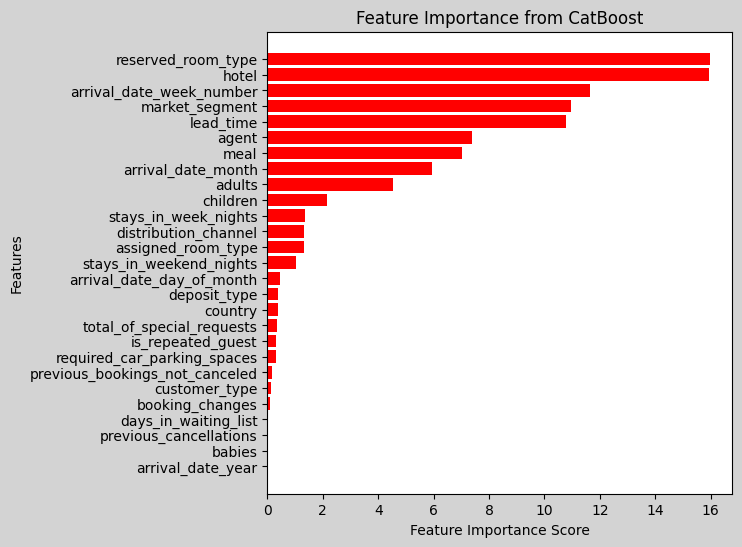

In [88]:
# Plotting feature importance
plt.figure(figsize=(6,6), facecolor= "lightgray")
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='red')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance from CatBoost')

# Displaying the highest importance at the top
plt.gca().invert_yaxis() 
plt.show()

<span style="font-size: 19px;">**Feature Importance Results Analysis:**

- Room Type & Hotel Type dominate, reinforcing that base pricing depends heavily on the type of accommodation.
- Seasonality (Week Number, Month) & Booking Channel (Market Segment, Agent) play a major role in ADR fluctuations.
- Guest Composition (Adults, Children) & Booking Characteristics (Lead Time, Meal Plan) also contribute but to a lesser extent.
  
The feature importance ranking suggests that a strong ADR prediction model should focus on room types, seasonality, and booking sources, with additional refinement through guest demographics and lead time.

### Evaluation

**NOTE**: We are using only 20% of the data, and the focus here is not on optimizing performance, but rather on the process itself.

Mean Squared Error (MSE): MSE is a metric that measures the average squared difference between predicted and actual values, with larger values indicating worse model performance. MSE penalizes large errors heavily by squaring the error term meaning it's quite sensitive to outliers. 

Root Mean Squared Error (RMSE): The square root of MSE. It has the same unit as the target variable and gives a more interpretable measure of error.

In [631]:
# Predicting test data
y_pred = best_model.predict(X_test)

# Evaluating the model using mse
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Displaying the metrics
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 36.917636942554196


In [3]:
# Plot the learning curves (loss and metric)
#import catboost

#w = catboost.MetricVisualizer('/', subdirs=True)
#w.start()

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


We will make a comprehensive results analysis at the end of this section. 

## Ensemble Model: Random Forest (RF)

Random Forest is a robust ensemble learning algorithm that enhances predictive performance by aggregating multiple decision trees, reducing overfitting and improving generalization. Its ability to handle high-dimensional data and capture complex feature interactions makes it well-suited for regression tasks like ADR forecasting. Also, feature importance rankings from Random Forest provide valuable insights into the key drivers of hotel pricing and booking behavior.

**NOTE:** To ensure a fair comparison with CatBoost, we apply the same preprocessing steps and limit the training data to 20% of the total dataset.

In [257]:
from sklearn.ensemble import RandomForestRegressor

In [258]:
# Redoing the few first preprocessing steps.

# using the cleaned and processed version of the data
df = pd.read_csv("cleaned_and_prepared_data.csv")

# Mapping the months to their corresponding numerical values
month_mapping = {month: idx + 1 for idx, month in enumerate(ordered_months)}

# Applying the mapping to 'arrival_date_month'
df['arrival_date_month'] = df['arrival_date_month'].map(month_mapping)

# verifying the converted column
print(df['arrival_date_month'][:3])

# Creating a full date column (make sure columns have proper types)
df['full_date'] = pd.to_datetime({'year': df['arrival_date_year'],
                   'month': df['arrival_date_month'],'day': df['arrival_date_day_of_month']}) 

# Sorting by date
df = df.sort_values(by='full_date') 

# Extracting the last 20% of the data
df = df.iloc[-int(len(df) * 0.2):]
#df.shape

0    1
1    1
2    1
Name: arrival_date_month, dtype: int64


In [259]:
# Defining target and features 
X = df.drop(columns=["booking_id", "reservation_status", "reservation_status_date", "is_canceled", "adr"])
y = df["adr"]

# Identifying categorical features
categorical_features = [col for col in X.columns if X[col].dtype == 'object']

X['agent'] = X['agent'].astype(str)  # Converting all values to string
X['agent'] = X['agent'].str.lower()

X['is_repeated_guest'] = X['is_repeated_guest'].map({0: 'no', 1: 'yes'}).astype(str) # Converting all values to string 

print(X['agent'].unique())  # Evaluating unique values to find any possible unusual category

# Defining split index (80% for training)
split_index = int(len(X) * 0.8)

# Train-test split
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Dropping 'full_date' after sorting
X_train = X_train.drop(columns=['full_date'])
X_test = X_test.drop(columns=['full_date'])

['7.0' '28.0' '8.0' '14.0' '240.0' '-1.0' '9.0' '0.0' '40.0' '6.0' '241.0'
 '250.0' '1.0']


### Feature Engineering

Feature engineering involves creating new input features from raw data to improve the predictive power of a model. In the context of hotel ADR forecasting, it is crucial to create features that capture temporal patterns, booking trends, and guest behavior. Below are examples of potential features:

#### Time-Series Specific Features

**Lag Features:**

Creating lag variables allows the model to use past ADR values to predict future values. For example, ADR from the previous week or month could be highly predictive of future prices.

**Rolling Statistics:**

Moving averages or rolling sums can capture trends in ADR over time, smoothing out short-term fluctuations and emphasizing longer-term patterns.

In [260]:
# Lag Features
df['adr_lag_1'] = df['adr'].shift(1)  # Previous day's ADR
df['adr_lag_7'] = df['adr'].shift(7)  # ADR from 7 days ago
df['adr_lag_30'] = df['adr'].shift(30)  # ADR from 30 days ago

In [261]:
# Rolling Statistics 
# .shift(1) to ensure only past data is used
df['adr_rolling_mean_7'] = df['adr'].shift(1).rolling(window=7, min_periods=1).mean()
df['adr_rolling_mean_30'] = df['adr'].shift(1).rolling(window=30, min_periods=1).mean()
df['adr_rolling_max_7'] = df['adr'].shift(1).rolling(window=7, min_periods=1).max()

# NOTE: min_periods=1 allows calculations even when there are fewer than n values available

**NOTE:** 

The newly added time-series features may introduce NaN values. To handle this, we can either drop them, which reduces the dataset size, or apply the forward fill method to propagate the last known values (or other methods to fill null values).

Forward filling (ffill) is safer for time series, as opposed to Backward filling, it maintains the temporal integrity of the data by using past information to fill missing values. This ensures that the model does not unintentionally use future data when making predictions. In contrast, backward filling (bfill) fills in missing values using future observations, which can introduce data leakage by allowing the model to learn from information that would not be available at the time of prediction.

In [262]:
df.isnull().sum()              

hotel                              0
is_canceled                        0
lead_time                          0
arrival_date_year                  0
arrival_date_month                 0
arrival_date_week_number           0
arrival_date_day_of_month          0
stays_in_weekend_nights            0
stays_in_week_nights               0
adults                             0
children                           0
babies                             0
meal                               0
country                            0
market_segment                     0
distribution_channel               0
is_repeated_guest                  0
previous_cancellations             0
previous_bookings_not_canceled     0
reserved_room_type                 0
assigned_room_type                 0
booking_changes                    0
deposit_type                       0
agent                              0
days_in_waiting_list               0
customer_type                      0
adr                                0
r

In [263]:
df.fillna(method='ffill', inplace=True)

#### Non-Time-Series Specific Features

**Total Stay Duration**

The length of stay (weekdays + weekends) affects ADR, as hotels may offer discounts for longer stays.

**Weekend Stay Indicator**

Some hotels charge more for weekend stays, and having a binary feature can help the model capture this trend.

**Booking Lead Time Category**

Categorizing lead time into groups (e.g., last-minute vs. early) can help the model capture pricing trends.

In [264]:
# Total Stay Duration
df['total_stay'] = df['stays_in_week_nights'] + df['stays_in_weekend_nights']

In [265]:
# Weekend Stay Indicator
df['is_weekend_stay'] = (df['stays_in_weekend_nights'] > 0).astype(str)

In [266]:
# Booking Lead Time Category
df['lead_time_category'] = pd.cut(df['lead_time'], bins=[0, 7, 30, 90, 365], 
                                  labels=['Last-minute', 'Short-term', 'Mid-term', 'Long-term']).astype('object')

### RF with New Features

Random Forest models are trained using the whole dataset. (as  opposed to the CatBoost with 20% of the data)

In [267]:
df.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'booking_id',
       'full_date', 'adr_lag_1', 'adr_lag_7', 'adr_lag_30',
       'adr_rolling_mean_7', 'adr_rolling_mean_30', 'adr_rolling_max_7',
       'total_stay', 'is_weekend_stay', 'lead_time_category'],
      dtype='object')

In [268]:
# Defining target and features 
X = df.drop(columns=["booking_id", "reservation_status", "reservation_status_date", "is_canceled", "adr"])
y = df["adr"]

# Identifying categorical features
categorical_features = [col for col in X.columns if X[col].dtype == 'object']

X['agent'] = X['agent'].astype(str)  # Converting all values to string
X['agent'] = X['agent'].str.lower()

X['is_repeated_guest'] = X['is_repeated_guest'].map({0: 'no', 1: 'yes'}).astype(str) # Converting all values to string 

print(X['agent'].unique())  # Evaluating unique values to find any possible unusual category

# Defining split index (80% for training)
split_index = int(len(X) * 0.8)

# Train-test split
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Dropping 'full_date' after sorting
X_train = X_train.drop(columns=['full_date'])
X_test = X_test.drop(columns=['full_date'])

['7.0' '28.0' '8.0' '14.0' '240.0' '-1.0' '9.0' '0.0' '40.0' '6.0' '241.0'
 '250.0' '1.0']


In [269]:
# Converting categorical columns to 'category' dtype
categorical_features = df.select_dtypes(include='object').columns
for col in categorical_features:
    df[col] = df[col].astype('category')

# Handling target variable (ADR) and features
# Dropping non-predictive columns
X = df.drop(['adr', 'reservation_status_date', 'full_date', 'booking_id', 'reservation_status', 'is_canceled'], axis=1)  
y = df['adr']

# One-hot encoding categorical variables 
X = pd.get_dummies(X, drop_first=True)

# Splitting the data chronologically into train and test sets
# Use the first 80% of the data for training and the last 20% for testing
train_size = int(len(df) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Instantiating and training the RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, random_state=10101)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=10101)

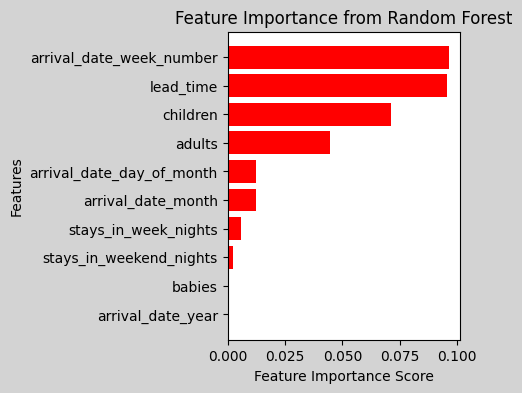

In [270]:
# Getting feature importances
importances = rf.feature_importances_

# Creating a DataFrame to hold the feature names and their importance scores
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

feature_importance_df = feature_importance_df.head(10)
# Sorting the DataFrame by importance score in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plotting feature importance
plt.figure(figsize=(3,4), facecolor="lightgray")
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='red')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance from Random Forest')

# Displaying the highest importance at the top
plt.gca().invert_yaxis()
plt.show()

In [271]:
# Making predictions
y_pred = rf.predict(X_test)

# Computing Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Computing RMSE by taking the square root of MSE
rmse = np.sqrt(mse)

print(f"Root Mean Squared Error: {rmse}")

Root Mean Squared Error: 27.30767303729634


### RF without New Features

In [272]:
df.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'booking_id',
       'full_date', 'adr_lag_1', 'adr_lag_7', 'adr_lag_30',
       'adr_rolling_mean_7', 'adr_rolling_mean_30', 'adr_rolling_max_7',
       'total_stay', 'is_weekend_stay', 'lead_time_category'],
      dtype='object')

In [273]:
# Handling target variable (ADR) and features
# Dropping non-predictive columns
X = df.drop(['adr', 'reservation_status_date', 'full_date', 'booking_id', 'reservation_status', 'is_canceled',
            'full_date', 'adr_lag_1', 'adr_lag_7', 'adr_lag_30', 'adr_rolling_mean_7', 'adr_rolling_mean_30', 'adr_rolling_max_7',
            'total_stay', 'is_weekend_stay', 'lead_time_category'], axis=1)  

y = df['adr']

# One-hot encoding categorical variables 
X = pd.get_dummies(X, drop_first=True)

# Splitting the data chronologically into train and test sets
# Use the first 80% of the data for training and the last 20% for testing
train_size = int(len(df) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Instantiating and training the RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, random_state=10001)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=10001)

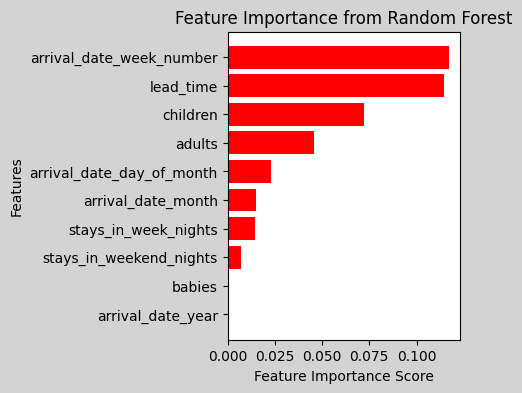

In [274]:
# Getting feature importances
importances = rf.feature_importances_

# Creating a DataFrame to hold the feature names and their importance scores
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

feature_importance_df = feature_importance_df.head(10)
# Sorting the DataFrame by importance score in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plotting feature importance
plt.figure(figsize=(3,4), facecolor="lightgray")
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='red')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance from Random Forest')

# Displaying the highest importance at the top
plt.gca().invert_yaxis()
plt.show()

In [275]:
# Making predictions
y_pred = rf.predict(X_test)

# Computing Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Computing RMSE by taking the square root of MSE
rmse = np.sqrt(mse)

print(f"Root Mean Squared Error: {rmse}")

Root Mean Squared Error: 26.591067363365543


RF with New Features:Root Mean Squared Error: 27.30767303729634 
RF without New Features: Root Mean Squared Error: 26.591067363365
CatBoost :Root Mean Squared Error (RMSE): 36.917636942


<span style="font-size: 22px;">**What This Means in Practice**


## Summary of the Results

Analysis of Model Performance and Feature Importance

<span style="font-size: 18px;">**1. RMSE Comparison Across Models**

We trained three models—Random Forest with newly added features, Random Forest without additional features, and CatBoost—using 20% of the dataset for a fair comparison. The RMSE values are as follows:

- Random Forest (with new features): 27.31
- Random Forest (without new features, same features as CatBoost): 26.59
- CatBoost: 36.92

<span style="font-size: 16px;">**Key Observations**

Both Random Forest models outperform CatBoost significantly in terms of RMSE and computational complexity.

The addition of new features did not improve the Random Forest model; in fact, it performed slightly worse (27.31 vs. 26.59).

CatBoost’s higher RMSE suggests it may not be well-tuned for this dataset, or it could be struggling with certain relationships in the data that Random Forest captures more effectively.

<span style="font-size: 16px;">**2. Feature Importance Comparison**
   
- The top-ranked features in both versions of the Random Forest model are:

arrival_date_week_number, lead_time, children, adults, arrival_date_day_of_month, arrival_date_year, stays_in_weekend_nights, stays_in_week_nights

Notably, none of the newly engineered features (e.g., lag features or stay durations) appear in the top 10.

- The top-ranked features of CatBoost model differ significantly from Random Forest’s.

reserved_room_type (17.91%) and hotel (14.92%) are the most important, whereas these do not rank highly in Random Forest.
arrival_date_week_number and lead_time are important in both models, but their ranking varies.

Features like market_segment and agent, which are highly ranked in CatBoost, do not appear in Random Forest’s top features.

<span style="font-size: 18px;">**3. Interpretation of Differences**

CatBoost emphasizes categorical features (reserved_room_type, hotel, market_segment, agent), likely due to its native handling of categorical data.

Random Forest focuses more on numerical features related to dates and stays, suggesting it may be better at capturing time-dependent patterns.

<span style="font-size: 16px;">**Why Do New Features Not Rank High in Random Forest?**

The newly added features (e.g., lag features) may not contribute significant new information beyond existing features.
They might be correlated with already important features, causing Random Forest to give them less weight.

<span style="font-size: 16px;">**Why Does CatBoost Perform Worse?**

CatBoost’s reliance on categorical features might indicate that numerical trends dominate ADR prediction.
It may require further hyperparameter tuning or different feature transformations to improve its performance.

<span style="font-size: 16px;">**Summary of Findings**

Random Forest (without new features) performs best (RMSE: 26.59), indicating the additional engineered features did not add value.
CatBoost ranks categorical features higher, whereas Random Forest prioritizes numerical ones related to time and stays.
The poorer performance of CatBoost suggests it may not be capturing key numerical relationships as effectively as Random Forest.
Future improvements could involve testing alternative feature engineering strategies, fine-tuning CatBoost, or exploring hybrid models that leverage both categorical and numerical strengths.

## Conclusion and Business Implications

Our analysis provides a data-driven approach to understanding hotel booking demand, cancellations, and pricing strategies. By examining key factors such as lead time, market segment, and previous cancellations, we identify patterns that impact revenue and operational efficiency.

One of the primary objectives was ADR (Average Daily Rate) forecasting, which helps hotels predict future booking trends. This insight allows businesses to:

- Optimize pricing strategies by adjusting rates based on demand fluctuations.
- Improve staffing and resource allocation by anticipating peak and low-demand periods.
- Reduce revenue losses by identifying factors contributing to cancellations and taking proactive measures.

<span style="font-size: 17px;">**Business Applications**

- Dynamic Pricing: Hotels can implement real-time pricing adjustments based on predicted demand, ensuring competitive yet profitable rates.
- Cancellation Mitigation: By analyzing which segments are more prone to cancellations, hotels can introduce stricter policies or targeted incentives (e.g., discounts for non-refundable bookings).
- Inventory and Staffing Management: Forecasting demand enables hotels to schedule staff more efficiently and allocate rooms effectively, reducing operational waste.
- Personalized Marketing: Understanding guest behavior allows for tailored promotions to specific customer segments, improving booking conversion rates.

<span style="font-size: 17px;">**Final Thoughts**

Leveraging machine learning models like Random Forest and CatBoost, we extracted insights into booking behavior, cancellation risks, and pricing optimization. By implementing these findings, hotels can maximize revenue, enhance operational efficiency, and improve guest satisfaction, ensuring a more sustainable and profitable business model.